In [1]:
import gc
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import optimizers as opt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set()

In [2]:
# utils
SEED = None

def set_random_seed(seed: int) -> int:
    """Sets the random seed for TensorFlow, numpy, python's random"""
    global SEED
    
    if seed is not None:
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        SEED = seed
        print(f'Random seed {seed} set.')


def tf_global_norm(tensors: list, **kwargs):
    norms = [tf.norm(x, **kwargs) for x in tensors]
    return tf.sqrt(tf.reduce_sum([norm * norm for norm in norms]))


def free_mem():
    return gc.collect()


def dataset_from_tensors(tensors, batch_size: int, split=0.25, seed=SEED):
    total_size = tensors[-1].shape[0]
    val_size = int(total_size * split)
    train_size = total_size - val_size
    
    dataset = tf.data.Dataset.from_tensor_slices(tensors)
    dataset = dataset.shuffle(buffer_size=1024)

    training_set = dataset.take(train_size)
    training_set = training_set.batch(batch_size)
    
    validation_set = dataset.skip(train_size).take(val_size)
    validation_set = validation_set.batch(batch_size)
    
    free_mem()
    return training_set, validation_set


In [3]:
set_random_seed(42)

Random seed 42 set.


## Data
---

In [4]:
class Dataset:
    SIGNAL_PATH = os.path.join('data', 'signal.csv')
    BACKGROUND_PATH = os.path.join('data', 'background.csv')

    def __init__(self, x_scaler=None, m_scaler=None):
        self.signal = None
        self.background = None
        
        self.ds = None
        self.columns = []
        self.train_df = None
        self.test_df = None
        
        self.x_scaler = x_scaler
        self.m_scaler = m_scaler
        
        self.train_features = None
        self.test_features = None
        self.train_labels = None
        self.test_labels = None
        self.train_mass = None
        self.test_mass = None
        
        # keep sample weights
        self.weights_df = None
    
    def load(self, keep_mass=None, bin_size=100, test_size=0.2, seed=SEED):
        if self.ds is not None:
            return

        print('[signal] loading...')
        self.signal = pd.read_csv(self.SIGNAL_PATH, dtype=np.float32, na_filter=False)
        
        print('[background] loading...')
        self.background = pd.read_csv(self.BACKGROUND_PATH, dtype=np.float32, na_filter=False)
        
        self.ds = pd.concat([self.signal, self.background])
        
        # select columns
        feature_columns = [
            "dimuon_deltar",
            "dimuon_deltaphi",
            "dimuon_deltaeta",
            "met_pt",
            "deltar_bjet1_dimuon",
            "deltapt_bjet1_dimuon",
            "deltaeta_bjet1_dimuon",
            "bjet_1_pt",
            "bjet_1_eta",
            "ljet_1_pt",
            "ljet_1_eta",
            "bjet_n",
            "ljet_n"]
        
        columns = dict(feature=feature_columns,
                       weight=['weight', 'PU_Weight'],
                       label=self.ds.columns[-1], mass=self.ds.columns[0])
        self.columns = columns
        
        # train-test split:
        self.train_df, self.test_df = train_test_split(self.ds, test_size=test_size, 
                                                       random_state=seed)
        # fit scaler (on "whole" training-set)
        if self.x_scaler is not None:
            self.x_scaler.fit(self.train_df[columns['feature']].values)
        
        if self.m_scaler is not None:
            self.m_scaler.fit(self.train_df[columns['mass']].unique().reshape((-1, 1)))
        
        # drop some mass
        if isinstance(keep_mass, (list, tuple, np.ndarray)):
            print('[selected masses]', keep_mass)
            self._select_mass(mass=keep_mass, bin_size=bin_size)
            
            self.train_df, self.test_df = train_test_split(self.ds, test_size=test_size, 
                                                           random_state=seed)
            free_mem()

        # select series
        self.train_features = self.train_df[columns['feature']]
        self.train_labels = self.train_df[columns['label']]
        self.train_mass = self.train_df[columns['mass']]
        
        self.test_features = self.test_df[columns['feature']]
        self.test_labels = self.test_df[columns['label']]
        self.test_mass = self.test_df[columns['mass']]
        
        # select "sample weights" for training data only
        self.weights_df = self.train_df[columns['weight']]
        
        print('dataset loaded.')
        free_mem()
    
    def get(self, mask=None) -> tuple:
        if mask is not None:
            features = self.test_features[mask].values
            labels = self.test_labels[mask].values
            mass = self.test_mass[mask].values
        else:
            features = self.train_features.values
            labels = self.train_labels.values
            mass = self.train_mass.values

        mass = mass.reshape((-1, 1))
        labels = labels.reshape((-1, 1))

        if self.x_scaler is not None:
            features = self.x_scaler.transform(features)
        
        if self.m_scaler is not None:
            mass = self.m_scaler.transform(mass)

        x = dict(x=features, m=mass)
        y = labels
        
        free_mem()
        return x, y
    
    def get_by_mass(self, mass: float, bin_size=100) -> dict:
        min_mass = mass - (bin_size / 2.0)
        max_mass = mass + (bin_size / 2.0)
        
        return self.get(mask=(self.test_mass >= min_mass) & (self.test_mass < max_mass))
    
    def _select_mass(self, mass: list, bin_size=100):
        """Selects only the given mass from the dataframe"""
        mask = np.full(shape=(len(self.ds),), fill_value=False)
        
        # get at which index there are the requested mass
        for m in mass:
            m_low = m - (bin_size / 2.0)
            m_upp = m + (bin_size / 2.0)
            
            mask |= (self.ds['mA'] >= m_low) & (self.ds['mA'] < m_upp)

        # select data
        self.ds = self.ds[mask]
        free_mem()
        

## Models definition
---

In [12]:
#@title
"""Dynamic step-dependent parameters: used as learning rate schedules"""

import tensorflow as tf

from typing import Union

from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers.schedules import LearningRateSchedule


class DynamicParameter:
    """Interface for learning rate schedule wrappers as dynamic-parameters"""
    def __init__(self):
        self._value = tf.Variable(initial_value=0.0, trainable=False, dtype=tf.float32)
        self.step = tf.Variable(initial_value=0, trainable=False, dtype=tf.int32)

    @property
    def value(self):
        return self._value.value()

    @property
    def variable(self):
        return self._value

    @value.setter
    def value(self, value):
        self._value.assign(value)

    @staticmethod
    def create(value: Union[float, int, LearningRateSchedule], **kwargs):
        """Converts a floating or LearningRateSchedule `value` into a DynamicParameter object"""
        if isinstance(value, (DynamicParameter, ScheduleWrapper)):
            return value

        if isinstance(value, (float, int)):
            return ConstantParameter(value)

        if isinstance(value, LearningRateSchedule):
            return ScheduleWrapper(schedule=value, **kwargs)

        raise ValueError(f'Parameter "value" should be not {type(value)}.')

    def __call__(self, *args, **kwargs):
        return self.value

    def __sub__(self, other):
        self._value.assign_sub(other)

    def __add__(self, other):
        self._value.assign_add(other)

    def serialize(self) -> dict:
        return dict(step=int(self.step.value()))

    def on_step(self):
        self.step.assign_add(delta=1)

    def load(self, config: dict):
        self.step.assign(value=config.get('step', 0))

    def get_config(self) -> dict:
        return {}


class ScheduleWrapper(LearningRateSchedule, DynamicParameter):
    """A wrapper for built-in tf.keras' learning rate schedules"""
    def __init__(self, schedule: LearningRateSchedule, min_value=1e-7, max_value=None):
        super().__init__()
        self.schedule = schedule
        self.min_value = tf.constant(min_value, dtype=tf.float32)

        if isinstance(max_value, (float, int)):
            self.max_value = tf.constant(max_value, dtype=tf.float32)
        else:
            self.max_value = None

        self._value.assign(value=self.schedule.initial_learning_rate)

    def __call__(self, *args, **kwargs):
        self.value = tf.maximum(self.min_value, self.schedule.__call__(self.step))

        if self.max_value:
            self.value = tf.minimum(self.value, self.max_value)

        return self.value

    def get_config(self) -> dict:
        return self.schedule.get_config()


class ConstantParameter(DynamicParameter):
    """A constant learning rate schedule that wraps a constant float learning rate value"""
    def __init__(self, value: float):
        super().__init__()
        self.value = value

    def __call__(self, *args, **kwargs):
        return self.value

    def serialize(self) -> dict:
        return {}


class ExponentialDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, steps: int, rate: float, staircase=False, min_value=0.0, max_value=None):
        super().__init__(schedule=schedules.ExponentialDecay(initial_learning_rate=float(initial_value),
                                                             decay_steps=int(steps), decay_rate=float(rate),
                                                             staircase=bool(staircase)),
                         min_value=min_value, max_value=max_value)


class StepDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, steps: int, rate: float, min_value=1e-7, max_value=None):
        super().__init__(schedule=schedules.ExponentialDecay(initial_learning_rate=float(initial_value),
                                                             decay_steps=int(steps), decay_rate=float(rate),
                                                             staircase=True),
                         min_value=min_value, max_value=max_value)


class LinearDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, end_value: float, steps: int, cycle=False):
        super().__init__(schedule=schedules.PolynomialDecay(initial_learning_rate=float(initial_value),
                                                            decay_steps=int(steps), end_learning_rate=float(end_value),
                                                            power=1.0, cycle=bool(cycle)))


class PolynomialDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, end_value: float, steps: int, power=1.0, cycle=False):
        super().__init__(schedule=schedules.PolynomialDecay(initial_learning_rate=float(initial_value),
                                                            decay_steps=int(steps), end_learning_rate=float(end_value),
                                                            power=power, cycle=bool(cycle)))


In [6]:
class PNN(Model):
    """A Parametric Neural Network (PNN) model with various way to condition *only* the input layer"""
    
    def __init__(self, input_shapes: dict, weight_decay=0.0, **kwargs):
        name = kwargs.pop('name', 'ParametricNN')
        
        inputs, outputs = self.structure(input_shapes, **kwargs)
        super().__init__(inputs, outputs, name=name)

        self.lr = None
        
        self.weight_decay = tf.constant(weight_decay, dtype=tf.float32)
        self.should_decay_weights = self.weight_decay > 0.0

    def compile(self, optimizer_class=opt.Adam, loss='binary_crossentropy', metrics=None, lr=0.001, **kwargs):
        self.lr = DynamicParameter.create(value=lr)
        optimizer = optimizer_class(learning_rate=self.lr, **kwargs)

        super().compile(optimizer, loss, metrics)

    def structure(self, shapes: dict, units=128, num_layers=2, activation='relu', conditioning='concat',
                  **kwargs) -> tuple:
        inspect = kwargs.pop('inspect', False)
        inputs = self.inputs_from_shapes(shapes)
        
        if conditioning == 'paper':
            # input concatenation
            x = concatenate(list(inputs.values()))
            
        elif conditioning == 'concat':
            # input concatenation + linear combination
            x = concatenate(list(inputs.values()))
            x = Dense(units=units, activation='linear', name='linear', **kwargs)(x)

        elif conditioning == 'scaling':
            # linear combination (m) + element-wise multiplication (x)
            x = inputs['x']
            m = inputs['m']

            scaling = Dense(units=x.shape[-1], activation='linear', 
                            name='scaling', **kwargs)(m)
            x = multiply([x, scaling])

        elif conditioning == 'sigmoid':
            # sigmoidal-gating
            x = inputs['x']
            m = inputs['m']

            scaling = Dense(units=x.shape[-1], activation='sigmoid', 
                            name='scaling', **kwargs)(m)
            x = multiply([x, scaling])

        elif conditioning == 'softmax':
            # softmax-gating
            x = inputs['x']
            m = inputs['m']

            scaling = Dense(units=x.shape[-1], activation='softmax', 
                            name='scaling', **kwargs)(m)
            x = multiply([x, scaling])

        elif conditioning == 'affine':
            # apply an affine transformation y = scale(m) * x + bias(m)
            x = inputs['x']
            m = inputs['m']

            scale = Dense(units=x.shape[-1], activation='linear', 
                            name='scale', **kwargs)(m)

            bias =  Dense(units=x.shape[-1], activation='linear', 
                            name='bias', **kwargs)(m)

            x = multiply([x, scale])
            x = add([x, bias])
        else:
            x = inputs['x']

        for _ in range(num_layers):
            x = Dense(units=units, activation=activation, **kwargs)(x)
        
        outputs = Dense(units=1, activation='sigmoid', **kwargs)(x)

        if inspect:
            return inputs, [outputs, x]

        return inputs, outputs

    @tf.function
    def train_step(self, batch):
        if isinstance(batch, tuple) and len(batch) == 1:
            batch = batch[0]
        
        if len(batch) == 3:
            x, labels, sample_weight = batch
        else:
            x, labels = batch
            sample_weight = tf.ones_like(labels)
        
        with tf.GradientTape() as tape:
            classes = self(x, training=True)
            loss = self.compiled_loss(labels, classes, sample_weight=sample_weight)
            
            weight_norm, l2_loss = self.decay_weights()
            total_loss = loss + l2_loss
            
        global_norm, lr = self.apply_gradients(tape, loss)
        self.lr.on_step()

        debug = self.update_metrics(labels, classes, sample_weight=sample_weight)
        debug['loss'] = tf.reduce_mean(loss)
        debug['lr'] = lr
        debug['norm'] = global_norm
        debug['weight-norm'] = weight_norm
        debug['l2-loss'] = l2_loss
        
        return debug
    
    def apply_gradients(self, tape, loss):
        variables = self.trainable_variables

        grads = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(grads, variables))

        return tf_global_norm(grads), self.lr.value
    
    def decay_weights(self) -> tuple:
        weight_norm = tf_global_norm(self.trainable_variables)
            
        if self.should_decay_weights:
            l2_loss = weight_norm * self.weight_decay
        else:
            weight_norm = tf.stop_gradient(weight_norm)
            l2_loss = 0.0
        
        return weight_norm, l2_loss
    
    def update_metrics(self, true, predicted, sample_weight=None) -> dict:
        self.compiled_metrics.update_state(true, predicted, sample_weight=sample_weight)

        return {metric.name: metric.result() for metric in self.metrics}

    @staticmethod
    def inputs_from_shapes(shapes: dict) -> dict:
        return {name: Input(shape=shape, name=name) for name, shape in shapes.items()}


In [7]:
class AffineConditioning(Layer):
    """Affine transform-based conditioning layer"""

    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.kwargs = kwargs

        self.dense_scale: Dense = None
        self.dense_bias: Dense = None

        self.multiply = Multiply()
        self.add = Add()

    def build(self, input_shape):
        shape, _ = input_shape
        self.dense_scale = Dense(units=shape[-1], activation='linear', **self.kwargs)
        self.dense_bias = Dense(units=shape[-1], activation='linear', **self.kwargs)

    def call(self, inputs, **kwargs):
        assert isinstance(inputs, (list, tuple))
        assert len(inputs) == 2

        # condition input `x` on `z`
        x, z = inputs

        scale = self.dense_scale(z)
        bias = self.dense_bias(z)

        # apply affine transformation, i.e. y = scale(z) * x + bias(z)
        y = self.multiply([x, scale])
        y = self.add([y, bias])
        return y


class AffinePNN(PNN):
    """A PNN that uses Affine conditioning for all layers, not only the Input layer"""
    
    def __init__(self, *args, weight_decay=0.0, class_weights=None, mass_weights=None, mass_bins=None, 
                 mass_interval=50, mass_scaler=None, **kwargs):
        super().__init__(*args, weight_decay=weight_decay, **kwargs)
        
#         # class weights
#         if class_weights is None:
#             self.class_weights = tf.constant([0.5, 0.5], dtype=tf.float32)
#         else:
#             assert isinstance(class_weights, (tuple, list, np.ndarray))
#             assert len(class_weights) == 2
            
#             self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        
        # mass weights
        if isinstance(mass_weights, (list, tuple, np.ndarray)):
            assert len(mass_weights) >= 1
            assert isinstance(mass_bins, (list, tuple, np.ndarray))
            
            bins = tf.squeeze(mass_bins)
            
            self.mass_low = bins - mass_interval
            self.mass_high = bins + mass_interval
            
            # scale bins as input mass is scaled
            if mass_scaler is not None:
                self.mass_low = mass_scaler.transform(tf.reshape(self.mass_low, shape=(-1, 1)))
                self.mass_low = tf.squeeze(self.mass_low)
                
                self.mass_high = mass_scaler.transform(tf.reshape(self.mass_high, shape=(-1, 1)))
                self.mass_high = tf.squeeze(self.mass_high)
            
            self.mass_low = tf.cast(self.mass_low, dtype=tf.float32)
            self.mass_high = tf.cast(self.mass_high, dtype=tf.float32)
            
            self.mass_weights = tf.squeeze(mass_weights)
        else:
            self.mass_weights = None
        
    def structure(self, shapes: dict, activation='relu', **kwargs) -> tuple:
        inputs = self.inputs_from_shapes(shapes)
        units = kwargs.pop('units')
        
        x = inputs['x']
        m = inputs['m']
        
        for i, unit in enumerate(units):
            x = Dense(units=unit, activation=activation, **kwargs)(x)
            x = AffineConditioning(name=f'affine-{i}')([x, m])
        
        out = Dense(units=1, activation='sigmoid', name='classes', **kwargs)(x)
        return inputs, out
    
    @tf.function
    def train_step(self, batch):
        if isinstance(batch, tuple) and len(batch) == 1:
            batch = batch[0]

        if len(batch) == 3:
            x, labels, sample_weight = batch
        else:
            x, labels = batch
        
#             class_weights = self.get_class_weights(labels)
            mass_weights = self.get_mass_weights(features=x, labels=labels)
        
            # compute final weight for each sample
#             sample_weight = class_weights * mass_weights
            sample_weight = mass_weights
        
        with tf.GradientTape() as tape:
            classes = self(x, training=True)
            
            loss = self.compiled_loss(labels, classes, 
                                      sample_weight=sample_weight)
            
            weight_norm, l2_loss = self.decay_weights()
            total_loss = loss + l2_loss
        
        global_norm, lr = self.apply_gradients(tape, total_loss)
        self.lr.on_step()
        
        debug = self.update_metrics(labels, classes, sample_weight=sample_weight)
        debug['total_loss'] = tf.reduce_mean(total_loss)
        debug['loss'] = tf.reduce_mean(loss)
        debug['lr'] = lr
        debug['norm'] = global_norm
        debug['weight-norm'] = weight_norm
        debug['l2_loss'] = l2_loss
    
        return debug
    
#     def get_class_weights(self, labels):
#         if tf.is_tensor(self.class_weights):
#             class_weights = tf.where(labels == 0.0, x=self.class_weights[0], y=self.class_weights[1])
#             class_weights = tf.reshape(class_weights, shape=(-1, 1))
#         else:
#             class_weights = tf.ones_like(labels)
        
#         return class_weights
    
    def get_mass_weights(self, features, labels):
        if ('m' in features) and tf.is_tensor(self.mass_weights):
            mass = tf.cast(features['m'], dtype=tf.float32)
            
            # find which mass falls in which bin
            mask = (mass >= self.mass_low) & (mass < self.mass_high)
            bins = tf.argmax(tf.cast(mask, dtype=tf.int32), axis=-1)

            # index by bin and label
            indices = tf.concat([bins[:, None], tf.cast(labels, dtype=tf.int64)], axis=-1)

            # retrieve weights
            mass_weights = tf.gather_nd(self.mass_weights, indices)
            mass_weights = tf.cast(mass_weights, dtype=tf.float32)[:, None]
        else:
            mass_weights = tf.ones_like(labels)
            
        return mass_weights
        

## Reproduce Paper Results
* WARNING: `Dataset` class will load a dataset that is different from the one used in the paper
---

In [8]:
# load data
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load()

free_mem()

x_train, y_train = data.get()

[signal] loading...
[background] loading...
dataset loaded.


In [9]:
batch_size = 100
val_split = 0.25

In [10]:
# define model architecture as in Baldi t al.
weight_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=42)

paper_model = PNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), units=500, num_layers=5, 
            conditioning='paper', kernel_initializer=weight_init)
paper_model.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          7500        concatenate[0][0]     

In [13]:
# define optimizer and decaying learning rate schedule
decay_steps = int(y_train.shape[0] * (1.0 - val_split) / batch_size)

paper_lr_schedule = StepDecay(0.1, steps=decay_steps, rate=0.89)

paper_model.compile(optimizer_class=opt.SGD, momentum=0.5,
                    metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                    lr=paper_lr_schedule)

In [ ]:
# h = paper_model.fit(x=x_train, y=y_train, batch_size=batch_size,
#                     validation_split=val_split,
#                     epochs=10)  # the authors train for 200 epochs

In [14]:
# sample_weight = np.ones_like(y_train)  # CHANGE AS NEEDED!
sample_weight = data.weights_df['PU_Weight']

train_dataset, val_dataset = dataset_from_tensors((x_train, y_train, sample_weight), batch_size, split=val_split)

In [ ]:
# training with sample weights

h = paper_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

In [ ]:
paper_model.save_weights('my_weights/paper/weights')

### Training New Model (AffinePNN)
---
* Load training data

In [10]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load()

[signal] loading...
[background] loading...
dataset loaded.


In [120]:
free_mem()

In [12]:
x_train, y_train = data.get()

In [46]:
batch_size = 100
val_split = 0.25

* Affine-conditioned Parametric NN

In [72]:
# definition
model = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                  units=[300, 150, 100, 50])
model.summary()

# model.load_weights('my_weights/affine_model/weights')

decay_steps = int(y_train.shape[0] / batch_size * (1.0 - val_split))
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

model.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
              metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
              lr=lr_schedule)

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 300)          4200        x[0][0]                          
__________________________________________________________________________________________________
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
affine-0 (AffineConditioning)   (None, 300)          1200        dense_38[0][0]                   
                                                                 m[0][0]               

In [ ]:
# training
_ = model.fit(x=x_train, y=y_train, batch_size=batch_size,
              validation_split=val_split, epochs=10)

In [73]:
model.save_weights('my_weights/affine_model/weights')

In [14]:
model.load_weights('my_weights/affine_model/weights')

* Training with `class_weight` (dict):

In [66]:
# discover how imbalanced the classes are:

BKG_LABEL = 0
SIG_LABEL = 1

class_count = data.ds.shape[0]  # total number of samples

class_weights = {
    0: data.signal.shape[0] / class_count,  # weight for background
    1: data.background.shape[0] / class_count  # weight for signal
}


class_weights

{0: 0.43519348072636826, 1: 0.5648065192736317}

In [ ]:
cw_model = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                     units=[300, 150, 100, 50])
# cw_model.summary()

decay_steps = int(y_train.shape[0] / batch_size * 0.75)
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

cw_model.compile(optimizer_class=opt.Adam, # epsilon=0.0003125,
                 metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                 lr=lr_schedule)

_ = cw_model.fit(x=x_train, y=y_train, batch_size=batch_size, class_weight=class_weights,
                 validation_split=val_split, epochs=10)

* Training with `sample_weight`:

In [ ]:
sw_model = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                     units=[300, 150, 100, 50])

decay_steps = int(y_train.shape[0] / batch_size * (1.0 - val_split))
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

sw_model.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
                 metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                 lr=lr_schedule)

# sample_weights
sample_weight = data.weights_df['PU_Weight']
train_set, val_set = dataset_from_tensors((x_train, y_train, sample_weight), batch_size, split=val_split)

_ = sw_model.fit(train_set, validation_data=val_set, epochs=10)

* Training with `mass_weights` (tuple, list) requires:
    1. `mass_bins` a vector like $[100, 200,... 1000]$ of single mass values,
    2. `mass_interval` (default 50), i.e. the width of each bin, and
    3. `mass_weights` a vector of the same size of `mass_bins`, e.g. $[0.6, 0.3, ..., 0.1]$

In [68]:
# discover mass imbalance

def get_mass_weights(mass: list, bin_size=50):
    """Returns an np.array in which for each bin there are two weights: one for BKG, and the other for SIG"""
    mass = np.array(mass)
    
    mass_low = (mass - bin_size)[None, :]
    mass_upp = (mass + bin_size)[None, :]
    
    mA = data.ds['mA'].values[:, None]
    label = data.ds['type'].values
    
    # discover which mass is in which bin
    mask = (mA >= mass_low) & (mA < mass_upp)
    
    bins = np.argmax(mask, axis=-1)
    
    # make a DataFrame of bins and respective labels
    df = pd.DataFrame({'bin': bins, 'label': label})
    
    # count bins in signal and bkg
    counts = df.groupby(['bin', 'label']).size()
    
    # compute weights for each bin and label
    weights = []
    
    for bin, _ in enumerate(mass):
        count = counts[bin].values
        
        w = count / count.sum()
        weights.append(1.0 - w)
    
    free_mem()
    return np.array(weights)


In [69]:
mass_bins = np.arange(100, 1100, 100)

mass_weights = get_mass_weights(mass_bins)
mass_weights

array([[0.40756694, 0.59243306],
       [0.40170624, 0.59829376],
       [0.45034624, 0.54965376],
       [0.52123998, 0.47876002],
       [0.52283215, 0.47716785],
       [0.36388128, 0.63611872],
       [0.3651879 , 0.6348121 ],
       [0.36648239, 0.63351761],
       [0.36702779, 0.63297221],
       [0.54529925, 0.45470075]])

In [ ]:
mw_model = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                     units=[300, 150, 100, 50], mass_scaler=data.m_scaler,
                     mass_bins=mass_bins, mass_interval=50, mass_weights=mass_weights)
# mw_model.summary()

decay_steps = int(y_train.shape[0] / batch_size * (1.0 - val_split))
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

mw_model.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
                 metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                 lr=lr_schedule)

_ = mw_model.fit(x=x_train, y=y_train, batch_size=batch_size,
                 validation_split=val_split, epochs=10)

### Testing
* Compare AUC metric towards various mass [`auc_vs_mass`]
* Compare AUC metric versus a constant mass (either seen or not during training) [`auc_vs_no_mass`]
* Plot all the metrics w.r.t. the mass [`metrics_vs_mass`]
* Compare AUC vs mass when some (or all) features from $x$ are dropped [`auc_vs_mass_no_features`]
* Generalization capability by interpolation between unknown (not trained on) mass
---

In [79]:
def check_underflow(metric, control_metric) -> float:
    if metric == 0.0 and control_metric >= 0.9:
        return 1.0  # underflow occurred (metric would be wrongly 0.0)
    
    return metric  # no uderflow


def auc_vs_mass(model, dataset, auc_index: int, masses, bin_size=50, figsize=(26, 20)):
    plt.figure(figsize=figsize)

    mass = sorted(masses)
    auc = []

    for m in mass:
        x, y = dataset.get_by_mass(m, bin_size)
        
        print(f'Mass: {m}')
        score = model.evaluate(x=x, y=y, batch_size=128, verbose=1)
        
        auc_score = round(score[auc_index], 4)
        auc.append(check_underflow(auc_score, score[1]))
    
    
    plt.title(f'AUC vs Mass')
    plt.plot(mass, auc)
    plt.scatter(mass, auc, s=50, color='b')
    
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.show()
    return auc


def auc_vs_no_mass(model, dataset, auc_index: int, masses, const=[0], bin_size=50, figsize=(26, 20)):
    plt.figure(figsize=figsize)

    mass = sorted(masses)
    auc = {m: [] for m in const}

    for m in mass:
        x, y = dataset.get_by_mass(m, bin_size)
        
        for fake_m in const:
            x['m'] = np.ones_like(x['m']) * fake_m
        
            score = model.evaluate(x=x, y=y, batch_size=128, verbose=1)
            
            auc_score = round(score[auc_index], 4)
            auc[fake_m].append(check_underflow(auc_score, score[1]))
    
    plt.title(f'AUC vs Mass')
    
    for fake_m in const:
        plt.plot(mass, auc[fake_m], label=f'm-{fake_m}')
        plt.scatter(mass, auc[fake_m], s=50)
        
    plt.legend(loc='best')
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.show()
    return auc



def metrics_vs_mass(models: dict, dataset, metrics: list, rows: int, cols: int, 
                    figsize=(26, 20)):
    plt.figure(figsize=figsize)

    mass = list(dataset.unique_mass)
    scores = {key: [[] for _ in range(len(metrics))] for key in models.keys()}

    for m in dataset.unique_mass:
        x, y = dataset.get_by_mass(m)
        
        for label, model in models.items():
            score = model.evaluate(x=x, y=y, batch_size=128, verbose=1)
            # print(f'[m={m}] {str(score)}')

            for i, value in enumerate(score):
                scores[label][i].append(value)

    for i, name in enumerate(metrics):
        plt.subplot(rows, cols, i + 1)
        plt.title(f'{name} vs mass')

        for label in models.keys():
            plt.plot(mass, scores[label][i], label=label)
        
        plt.legend(loc='best')
        plt.ylabel(name)
        plt.xlabel('Mass')
    
    plt.show()
    return scores


In [86]:
mass = list(range(100, 1100, 100))

496/496 [==============================] - 2s 4ms/step - loss: 0.0332 - binary_accuracy: 0.9927 - auc_1: 0.9970 - precision_1: 0.9872 - recall_1: 0.9995


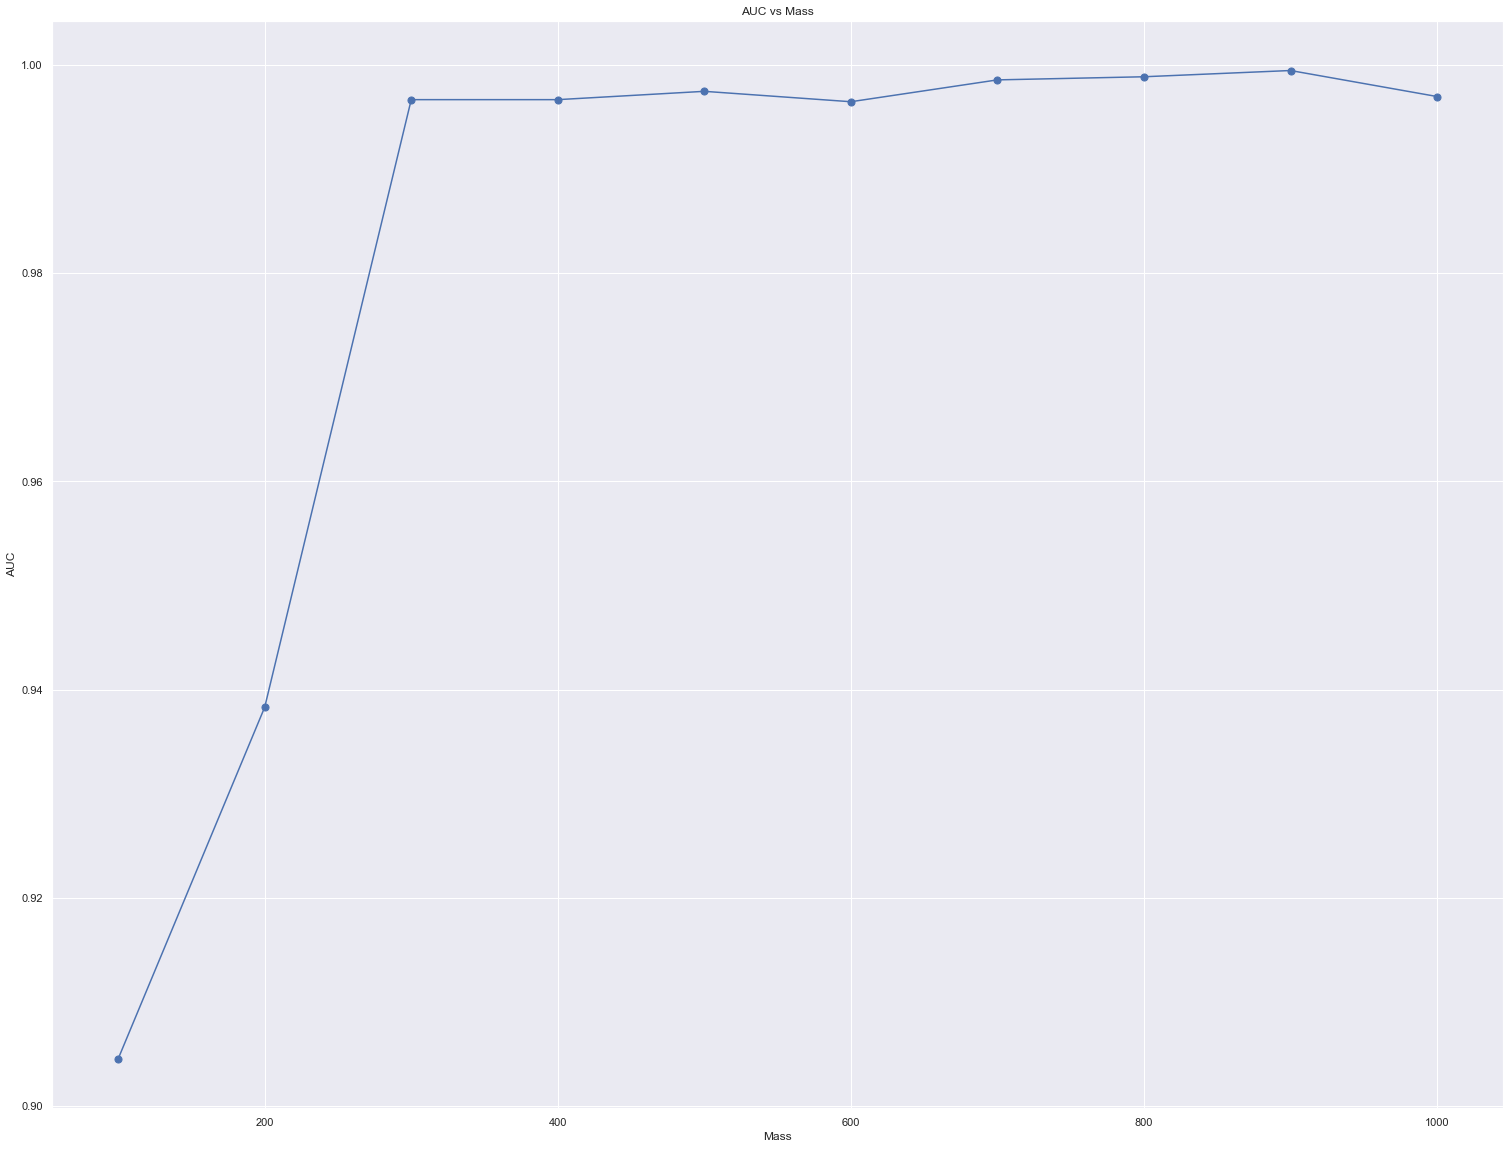

[0.9045, 0.9383, 0.9967, 0.9967, 0.9975, 0.9965, 0.9986, 0.9989, 0.9995, 0.997]

In [47]:
auc_vs_mass(model, data, auc_index=2, masses=mass, bin_size=100)

In [54]:
# training mass
data.signal['mA'].unique()

array([ 110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,  190.,
        200.,  225.,  250.,  275.,  300.,  350.,  400.,  450.,  500.,
        600.,  700.,  800.,  900., 1000.], dtype=float32)

* Signal mass

Mass: 110.0
71/71 [==============================] - 0s 4ms/step - loss: 0.3707 - binary_accuracy: 0.8183 - auc_1: 0.9211 - precision_1: 0.6853 - recall_1: 0.8952
Mass: 120.0
147/147 [==============================] - 1s 4ms/step - loss: 0.3716 - binary_accuracy: 0.8209 - auc_1: 0.9124 - precision_1: 0.7186 - recall_1: 0.8741
Mass: 130.0
156/156 [==============================] - 1s 4ms/step - loss: 0.3786 - binary_accuracy: 0.8190 - auc_1: 0.9043 - precision_1: 0.7496 - recall_1: 0.8470
Mass: 140.0
158/158 [==============================] - 1s 4ms/step - loss: 0.3881 - binary_accuracy: 0.8155 - auc_1: 0.8992 - precision_1: 0.7555 - recall_1: 0.8415
Mass: 150.0
160/160 [==============================] - 1s 4ms/step - loss: 0.3958 - binary_accuracy: 0.8136 - auc_1: 0.8954 - precision_1: 0.7539 - recall_1: 0.8507
Mass: 160.0
162/162 [==============================] - 1s 4ms/step - loss: 0.3966 - binary_accuracy: 0.8130 - auc_1: 0.8951 - precision_1: 0.7485 - recall_1: 0.8584
Mass: 170.0


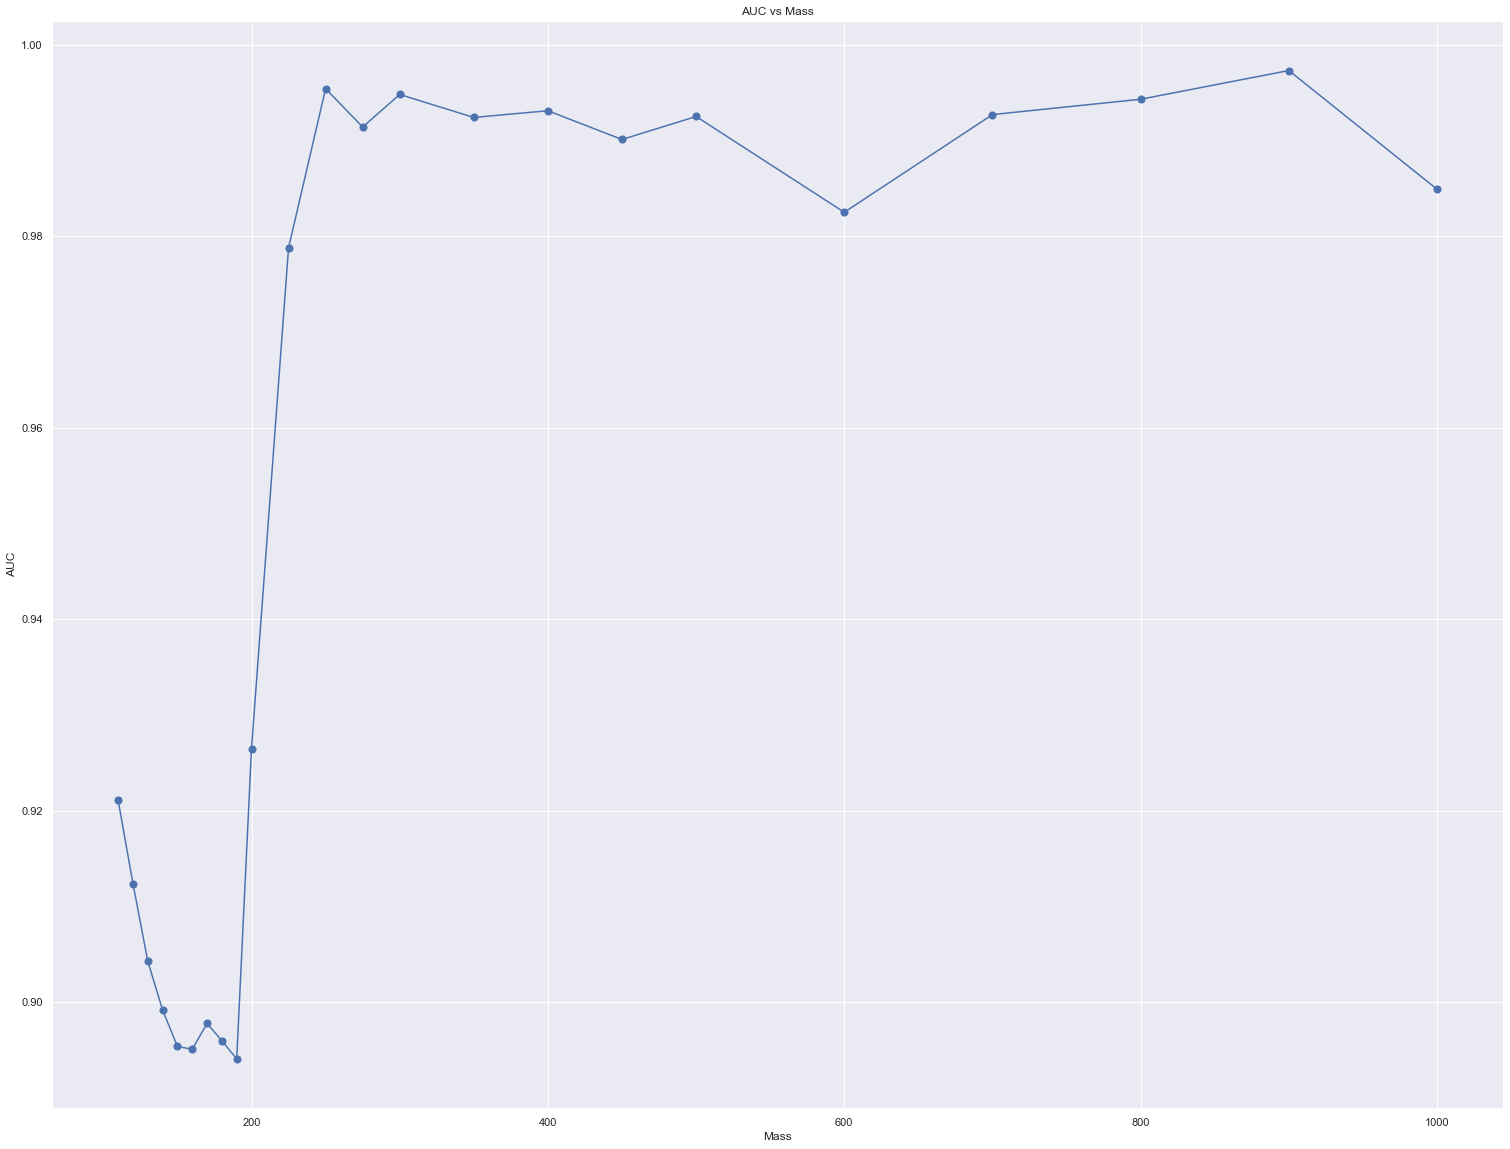

[0.9211,
 0.9124,
 0.9043,
 0.8992,
 0.8954,
 0.8951,
 0.8978,
 0.896,
 0.8941,
 0.9265,
 0.9788,
 0.9954,
 0.9914,
 0.9948,
 0.9924,
 0.9931,
 0.9901,
 0.9925,
 0.9825,
 0.9927,
 0.9943,
 0.9973,
 0.9849]

In [55]:
# test on *all* signal mass
delta = 20
mass= data.signal['mA'].unique()

auc_vs_mass(model, data, auc_index=2, masses=mass, bin_size=delta)


* Background mass

bkg-mass [ 110.          156.84210526  203.68421053  250.52631579  297.36842105
  344.21052632  391.05263158  437.89473684  484.73684211  531.57894737
  578.42105263  625.26315789  672.10526316  718.94736842  765.78947368
  812.63157895  859.47368421  906.31578947  953.15789474 1000.        ] 

Mass: 110.0
71/71 [==============================] - 0s 4ms/step - loss: 0.3707 - binary_accuracy: 0.8183 - auc_2: 0.9211 - precision_2: 0.6853 - recall_2: 0.8952
Mass: 156.8421052631579
162/162 [==============================] - 1s 4ms/step - loss: 0.3943 - binary_accuracy: 0.8149 - auc_2: 0.8970 - precision_2: 0.7525 - recall_2: 0.8584
Mass: 203.68421052631578
154/154 [==============================] - 1s 4ms/step - loss: 0.2983 - binary_accuracy: 0.8803 - auc_2: 0.9453 - precision_2: 0.8201 - recall_2: 0.8978
Mass: 250.5263157894737
153/153 [==============================] - 1s 4ms/step - loss: 0.0889 - binary_accuracy: 0.9661 - auc_2: 0.9953 - precision_2: 0.9322 - recall_2: 0.9875
Mass: 297

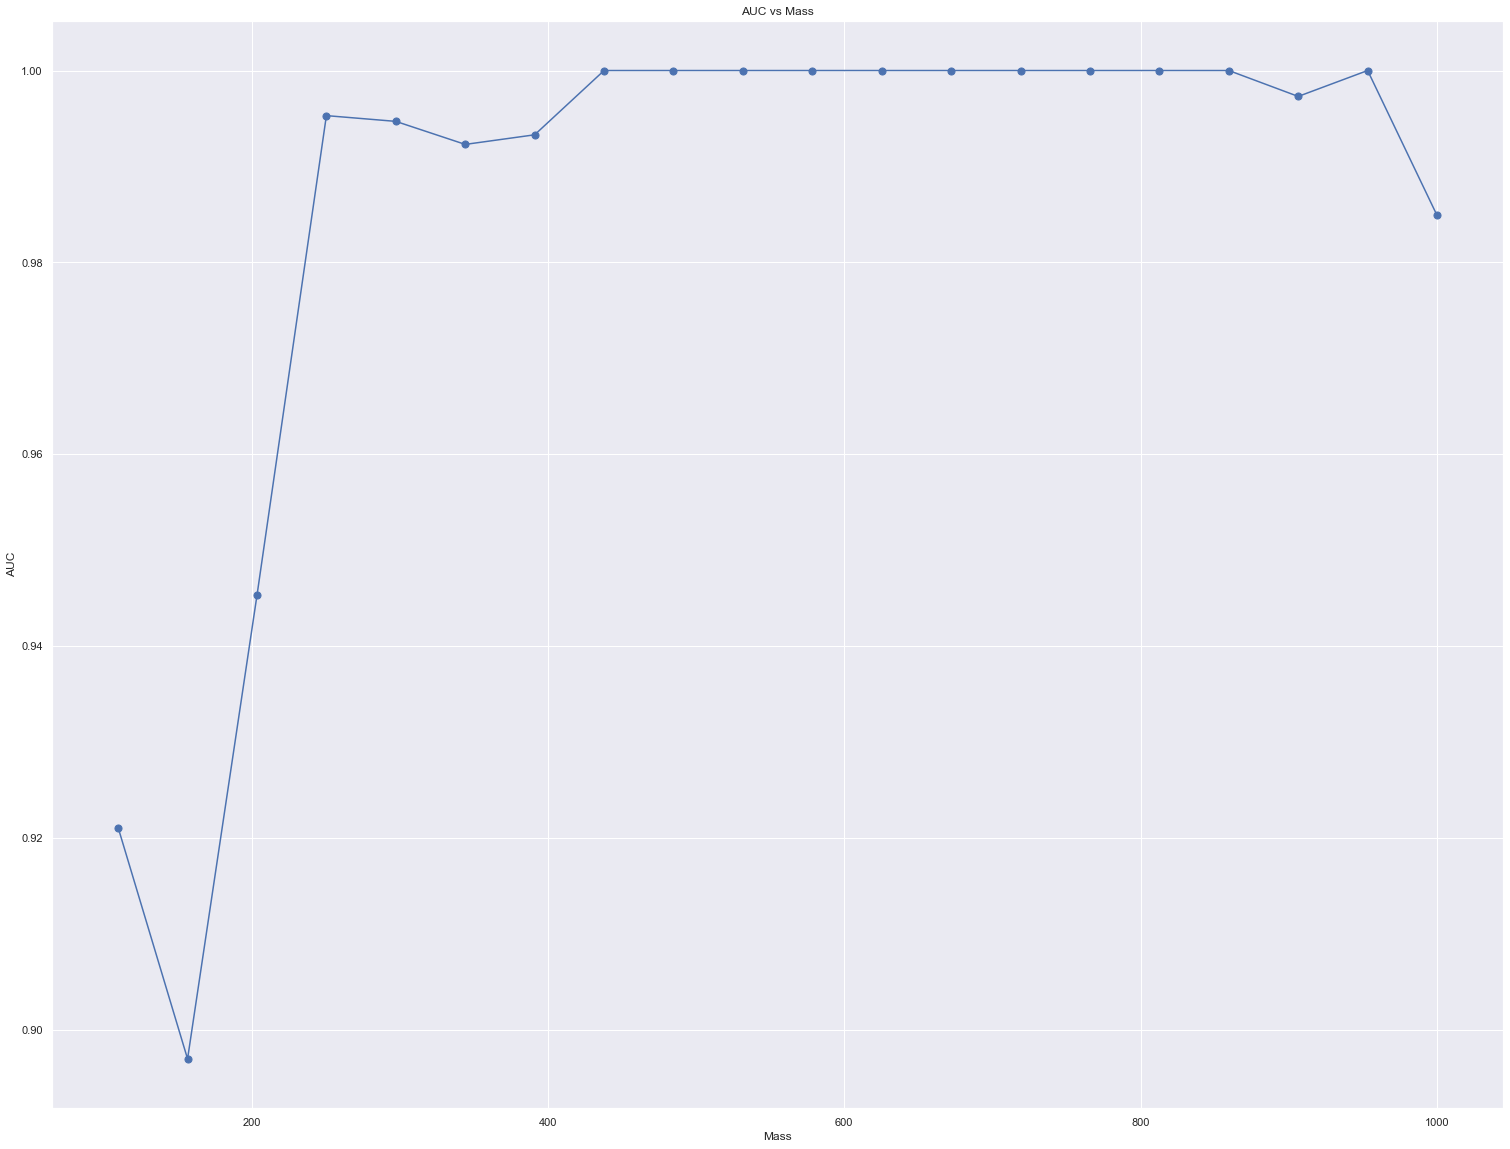

[0.9211,
 0.897,
 0.9453,
 0.9953,
 0.9947,
 0.9923,
 0.9933,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9973,
 1.0,
 0.9849]

In [40]:
# test on *binned* background mass

all_bkg_mass = data.background['mA'].round()
all_bkg_mass = sorted(all_bkg_mass.unique())

bin_size = 20
bkg_mass = np.linspace(min(all_bkg_mass), max(all_bkg_mass), bin_size)
print('bkg-mass', bkg_mass, '\n')

# 
auc_vs_mass(model, data, auc_index=2, masses=bkg_mass, bin_size=bin_size)

* Fake mass

496/496 [==============================] - 2s 4ms/step - loss: 2.1141 - binary_accuracy: 0.6551 - auc_1: 0.7793 - precision_1: 0.6124 - recall_1: 0.9995


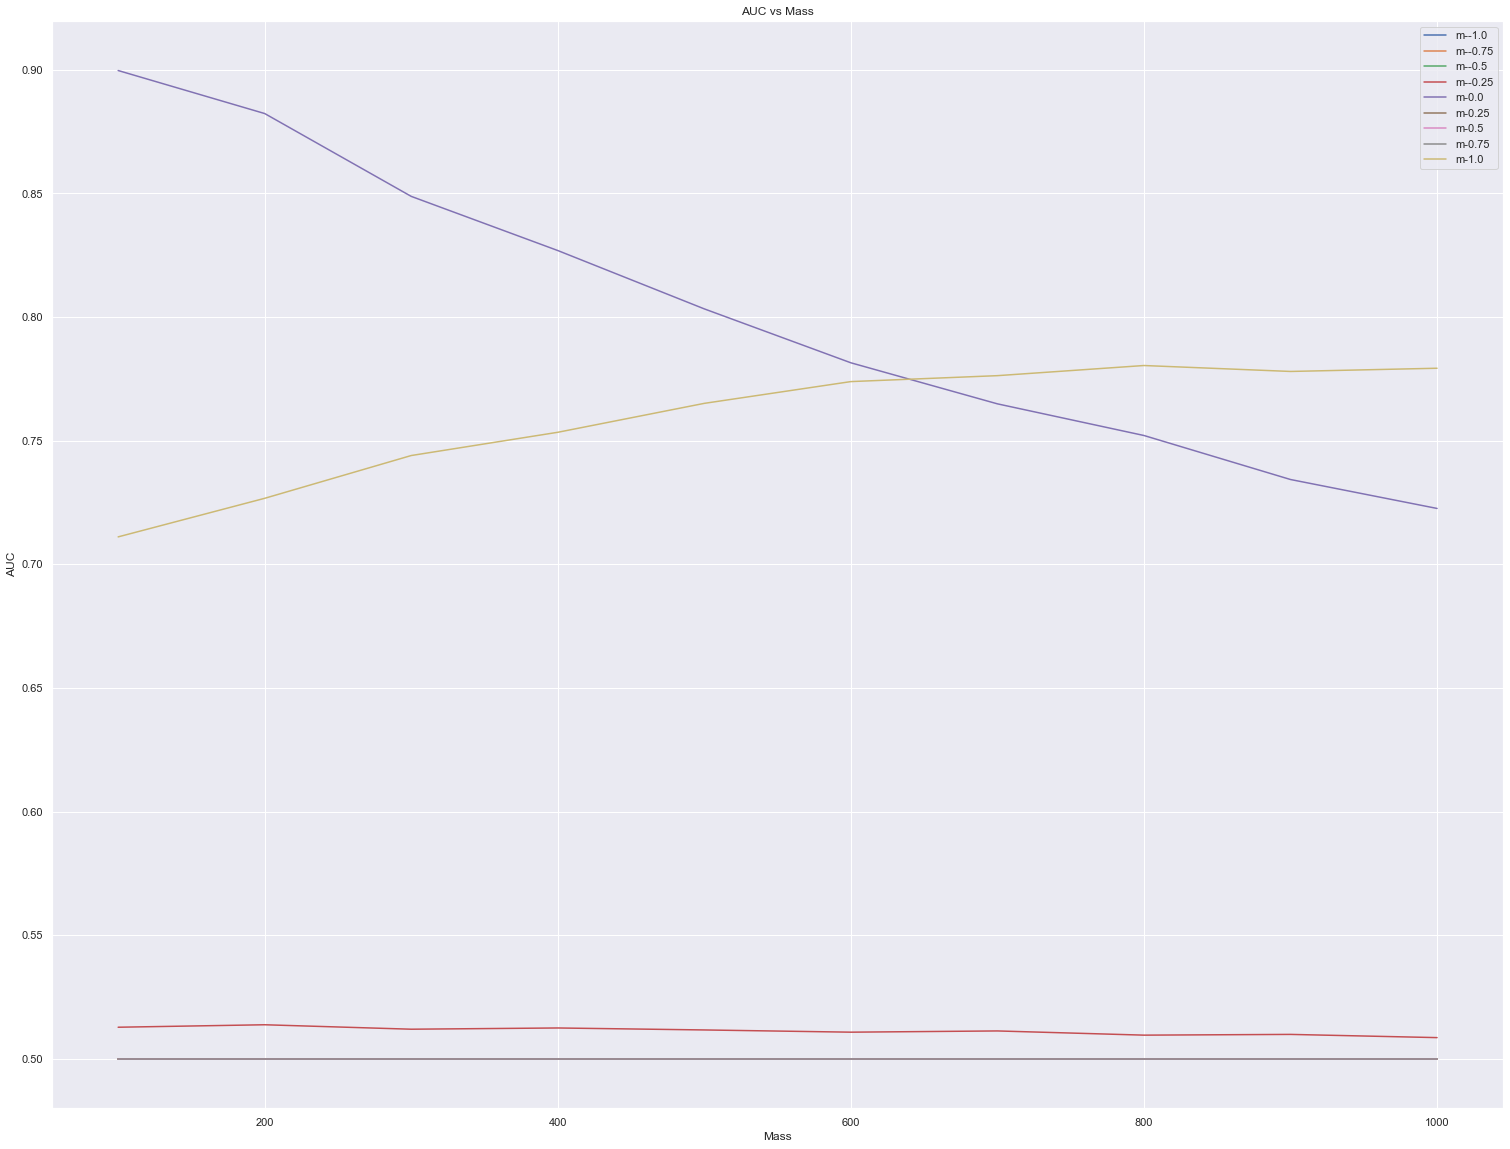

{-1.0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 -0.75: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 -0.5: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 -0.25: [0.5128,
  0.5138,
  0.512,
  0.5125,
  0.5117,
  0.5108,
  0.5113,
  0.5096,
  0.5099,
  0.5086],
 0.0: [0.8997,
  0.8823,
  0.8488,
  0.8269,
  0.8033,
  0.7815,
  0.7649,
  0.7521,
  0.7343,
  0.7226],
 0.25: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 0.5: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 0.75: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 1.0: [0.7111,
  0.7267,
  0.744,
  0.7534,
  0.7651,
  0.7739,
  0.7763,
  0.7804,
  0.778,
  0.7793]}

In [35]:
fake_mass = np.linspace(-100, 100, 9) / 100.0

auc_vs_no_mass(model, data, auc_index=2, masses=mass, const=fake_mass, bin_size=100)

In [ ]:
test_data = Dataset(scaler=MinMaxScaler())
test_data.load(path=Dataset.TEST_PATH)

loading dataset...
dataset loaded.


* How much the PNN relies on the features `x`?

Set some (or all) of them to zero and compute the AUC w.r.t. the mass.

In [41]:
def auc_vs_mass_no_features(model, dataset, auc_index: int, masses, bin_size=50, figsize=(26, 20),
                            features={}):
    plt.figure(figsize=figsize)

    mass = sorted(masses)
    auc = {k: [] for k in features.keys()}
    
    for label, indexes in features.items():
        print(f'Features: {label}, {indexes}')
        
        for m in mass:
            x, y = dataset.get_by_mass(m, bin_size)
        
            # mask features
            for i in indexes:
                zero_feature = np.zeros_like(x['x'][:, i])
                x['x'][:, i] = zero_feature
        
            print(f'Mass: {m}')
            score = model.evaluate(x=x, y=y, batch_size=128, verbose=1)
            
            auc_score = round(score[auc_index], 4)
            auc[LABEL].append(check_underflow(auc_score, score[1]))
            
            

    plt.title(f'AUC vs Mass')
    
    for label in features.keys():
        plt.plot(mass, auc[label])
        plt.scatter(mass, auc[label], s=50, label=label)
    
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.legend()
    plt.show()
    return auc

Features: all, []
Mass: 100
305/305 [==============================] - 1s 4ms/step - loss: 0.3801 - binary_accuracy: 0.8181 - auc: 0.9045 - precision: 0.7379 - recall: 0.8564
Mass: 200
764/764 [==============================] - 3s 4ms/step - loss: 0.3071 - binary_accuracy: 0.8656 - auc: 0.9383 - precision: 0.7964 - recall: 0.8930
Mass: 300
824/824 [==============================] - 3s 4ms/step - loss: 0.0593 - binary_accuracy: 0.9807 - auc: 0.9967 - precision: 0.9666 - recall: 0.9912
Mass: 400
945/945 [==============================] - 4s 4ms/step - loss: 0.0666 - binary_accuracy: 0.9787 - auc: 0.9967 - precision: 0.9672 - recall: 0.9928
Mass: 500
950/950 [==============================] - 4s 4ms/step - loss: 0.0553 - binary_accuracy: 0.9831 - auc: 0.9975 - precision: 0.9730 - recall: 0.9953
Mass: 600
712/712 [==============================] - 3s 4ms/step - loss: 0.0519 - binary_accuracy: 0.9837 - auc: 0.9965 - precision: 0.9590 - recall: 0.9976
Mass: 700
718/718 [=====================

764/764 [==============================] - 3s 4ms/step - loss: 0.3109 - binary_accuracy: 0.8647 - auc: 0.9374 - precision: 0.7956 - recall: 0.8913
Mass: 300
824/824 [==============================] - 3s 4ms/step - loss: 0.0590 - binary_accuracy: 0.9803 - auc: 0.9969 - precision: 0.9636 - recall: 0.9933
Mass: 400
945/945 [==============================] - 4s 4ms/step - loss: 0.0680 - binary_accuracy: 0.9777 - auc: 0.9965 - precision: 0.9641 - recall: 0.9943
Mass: 500
950/950 [==============================] - 4s 4ms/step - loss: 0.0557 - binary_accuracy: 0.9815 - auc: 0.9975 - precision: 0.9689 - recall: 0.9966
Mass: 600
712/712 [==============================] - 3s 4ms/step - loss: 0.0566 - binary_accuracy: 0.9823 - auc: 0.9962 - precision: 0.9552 - recall: 0.9980
Mass: 700
718/718 [==============================] - 3s 4ms/step - loss: 0.0472 - binary_accuracy: 0.9846 - auc: 0.9985 - precision: 0.9653 - recall: 0.9934
Mass: 800
712/712 [==============================] - 3s 4ms/step - l

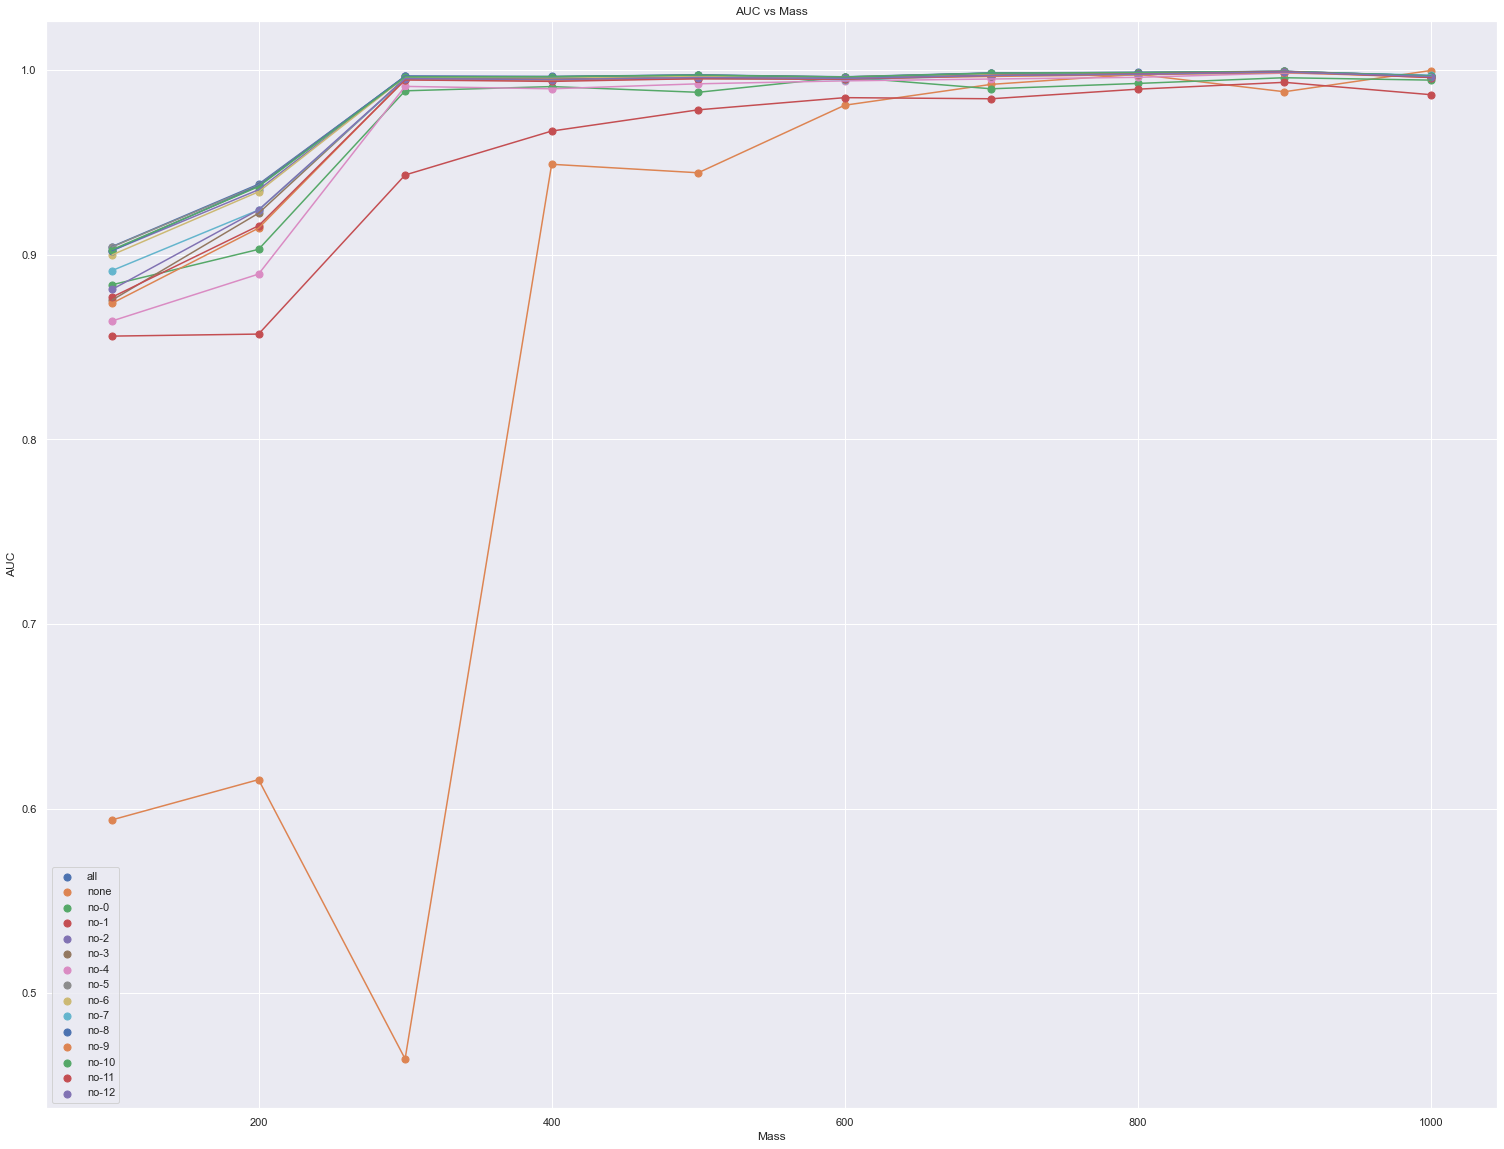

{'all': [0.9045,
  0.9383,
  0.9967,
  0.9967,
  0.9975,
  0.9965,
  0.9986,
  0.9989,
  0.9995,
  0.997],
 'none': [0.5939,
  0.6157,
  0.4644,
  0.9491,
  0.9445,
  0.9811,
  0.9924,
  0.9978,
  0.9884,
  0.9999],
 'no-0': [0.8838,
  0.903,
  0.9889,
  0.9912,
  0.9881,
  0.9964,
  0.99,
  0.9929,
  0.996,
  0.9947],
 'no-1': [0.856,
  0.8571,
  0.9433,
  0.9671,
  0.9786,
  0.9852,
  0.9846,
  0.9898,
  0.9935,
  0.9868],
 'no-2': [0.9023,
  0.9353,
  0.9965,
  0.9962,
  0.997,
  0.9961,
  0.9981,
  0.9984,
  0.9993,
  0.9967],
 'no-3': [0.8755,
  0.9226,
  0.9957,
  0.9954,
  0.9967,
  0.9951,
  0.9978,
  0.9984,
  0.9993,
  0.9966],
 'no-4': [0.8642,
  0.8896,
  0.9913,
  0.99,
  0.9927,
  0.9943,
  0.9953,
  0.9962,
  0.9985,
  0.9971],
 'no-5': [0.9043,
  0.9378,
  0.9967,
  0.9965,
  0.9973,
  0.9964,
  0.9984,
  0.9987,
  0.9994,
  0.997],
 'no-6': [0.9,
  0.9342,
  0.9964,
  0.996,
  0.9969,
  0.9963,
  0.9981,
  0.9986,
  0.9994,
  0.9969],
 'no-7': [0.8915,
  0.9243,
  0.99

In [28]:
features = {
    'all': [],
    'none': np.arange(0, 13),
}

# add an entry telling to drop only the i-th feature column
for i in range(13):
    features[f'no-{i}'] = [i]

auc_vs_mass_no_features(model, data, auc_index=2, masses=mass, bin_size=100, features=features)

* AUC with error bars

In [77]:
def split_dataset(dataset: Dataset, data: tuple, num_folds=10, seed=SEED):
    """Splits a given Dataframe into k disjoint folds"""
    fold_size = data[1].shape[0] // num_folds
    folds = []
    
    # first, construct a dataframe from data, where `data = dict(x, m), y`
    df = pd.concat([
        pd.DataFrame(data[0]['x'], columns=dataset.columns['feature']),
        pd.DataFrame(data[0]['m'], columns=['mass']),
        pd.DataFrame(data[1], columns=['label'])
    ], axis=1)
    
    for _ in range(num_folds - 1):
        fold = df.sample(fold_size, random_state=seed)
        folds.append(fold)
        
        df.drop(fold.index, inplace=True)
    
    folds.append(df)
    
    # make each `fold` be structured like `data`, i.e. fold = tuple(dict(x, m), y)
    for i, fold in enumerate(folds):
#         fold.reset_index(drop=True, inplace=True)
        
        fold_x = dict(x=fold[dataset.columns['feature']].values, 
                      m=fold['mass'].values)
        fold_y = fold['label'].values
    
        folds[i] = (fold_x, fold_y)
    
    return folds

In [75]:
def auc_with_error(model, dataset, auc_index: int, masses, bin_size=50, figsize=(26, 20), num_folds=10):
    plt.figure(figsize=figsize)

    mass = sorted(masses)
    auc = {fold: [] for fold in range(num_folds)}
    
    for m in mass:
        x, y = dataset.get_by_mass(m, bin_size)
        
        folds = split_dataset(dataset, data=(x, y), num_folds=num_folds)
        
        for i, fold in enumerate(folds):
            print(f'[{i}] Mass: {m}')
            score = model.evaluate(x=fold[0], y=fold[1], batch_size=128, verbose=1)

            auc_score = round(score[auc_index], 4)
            auc[i].append(check_underflow(auc_score, score[1]))
    
    # compute average AUC (over folds)
    avg_auc = []
    
    for i, _ in enumerate(mass):
        score = 0.0
        
        for fold in range(num_folds):
            score += auc[fold][i]
        
        avg_auc.append(round(score / num_folds, 4))
    
    plt.title(f'AUC vs Mass')
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.plot(mass, avg_auc, label='avg')
    plt.scatter(mass, avg_auc, s=50, color='b')
    
    for i in range(num_folds):
        plt.scatter(mass, auc[i], s=30, color='r')
    
    plt.show()
    return auc

[0] Mass: 100
13/13 [==============================] - 0s 3ms/step - loss: 0.3465 - binary_accuracy: 0.8455 - auc: 0.9249 - precision: 0.7907 - recall: 0.8780
[1] Mass: 100
13/13 [==============================] - 0s 3ms/step - loss: 0.3913 - binary_accuracy: 0.8186 - auc: 0.8976 - precision: 0.7774 - recall: 0.8742
[2] Mass: 100
13/13 [==============================] - 0s 3ms/step - loss: 0.3637 - binary_accuracy: 0.8299 - auc: 0.9140 - precision: 0.7796 - recall: 0.8844
[3] Mass: 100
13/13 [==============================] - 0s 3ms/step - loss: 0.4068 - binary_accuracy: 0.7980 - auc: 0.8879 - precision: 0.7459 - recall: 0.8591
[4] Mass: 100
13/13 [==============================] - 0s 3ms/step - loss: 0.3561 - binary_accuracy: 0.8349 - auc: 0.9205 - precision: 0.7682 - recall: 0.8803
[5] Mass: 100
13/13 [==============================] - 0s 3ms/step - loss: 0.3747 - binary_accuracy: 0.8180 - auc: 0.9072 - precision: 0.7522 - recall: 0.8714
[6] Mass: 100
13/13 [=========================

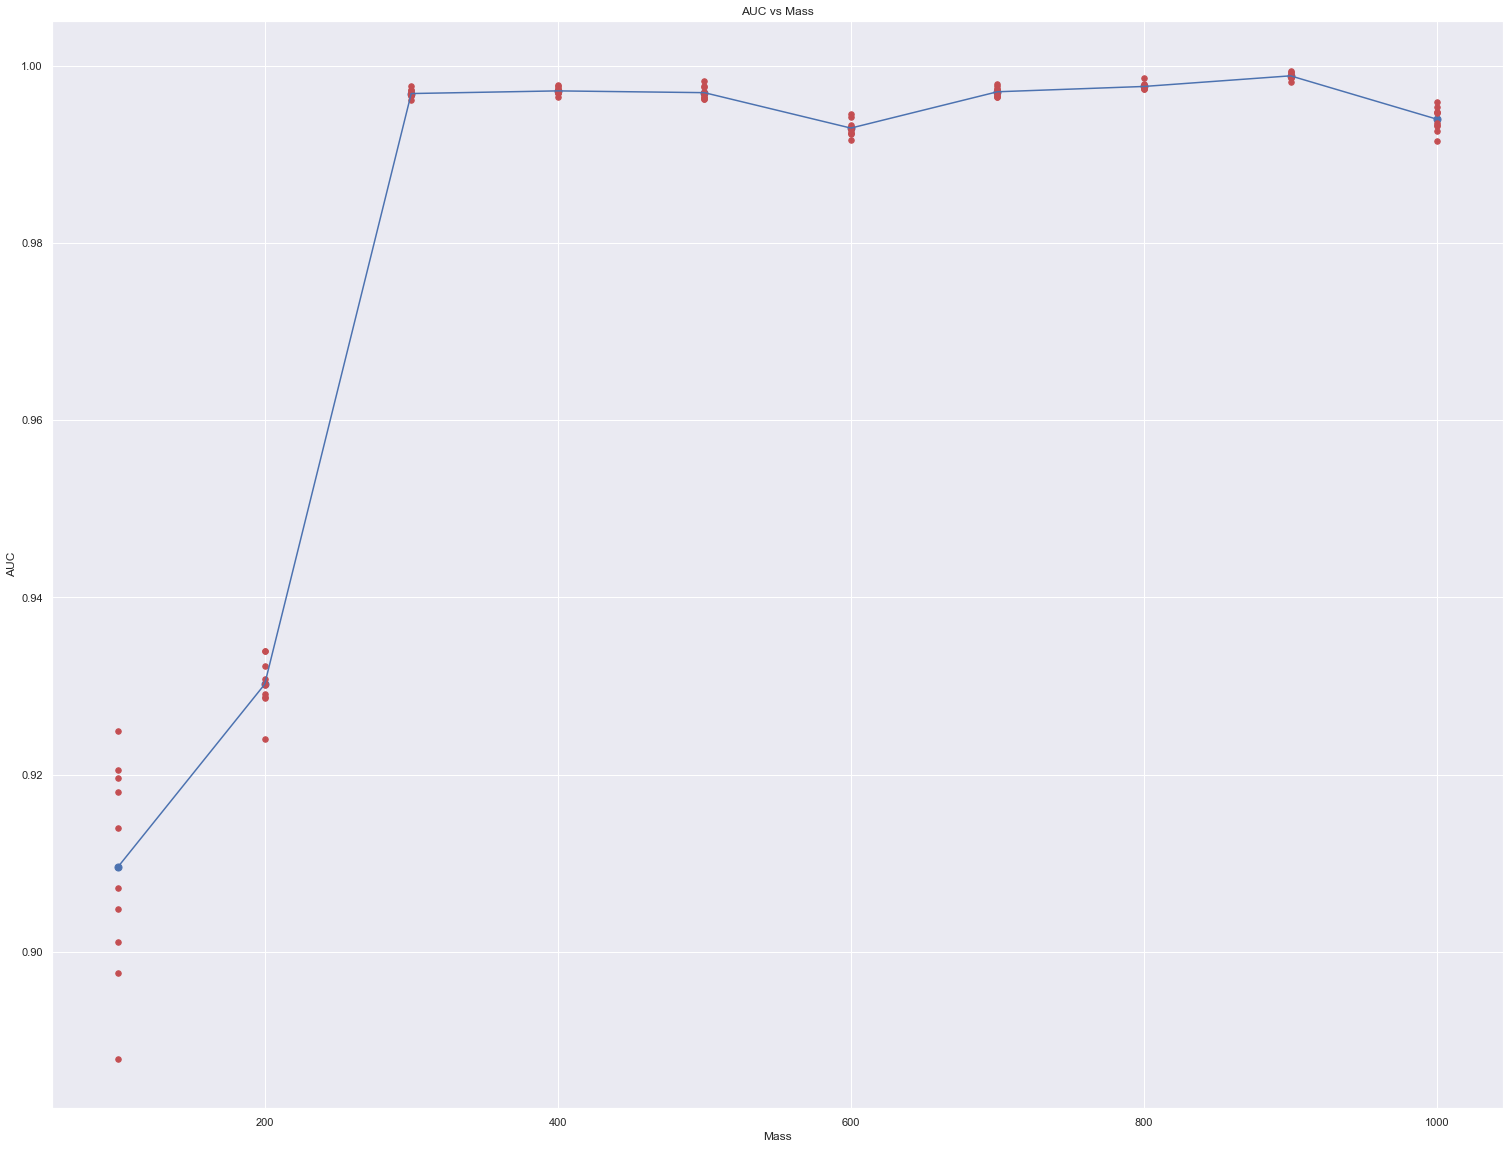

{0: [0.9249,
  0.9339,
  0.9977,
  0.9975,
  0.9978,
  0.9923,
  0.9967,
  0.9974,
  0.9988,
  0.9954],
 1: [0.8976,
  0.9288,
  0.9968,
  0.9979,
  0.997,
  0.9942,
  0.9965,
  0.998,
  0.9989,
  0.9959],
 2: [0.914,
  0.9287,
  0.9967,
  0.9973,
  0.9963,
  0.9946,
  0.9966,
  0.9978,
  0.9993,
  0.9947],
 3: [0.8879,
  0.9291,
  0.9966,
  0.9971,
  0.9976,
  0.9917,
  0.9974,
  0.9986,
  0.9988,
  0.9936],
 4: [0.9205,
  0.9339,
  0.9962,
  0.9977,
  0.9971,
  0.9931,
  0.9971,
  0.9974,
  0.9995,
  0.9934],
 5: [0.9072,
  0.9301,
  0.9971,
  0.997,
  0.9965,
  0.9929,
  0.9965,
  0.9975,
  0.9982,
  0.9948],
 6: [0.9011,
  0.924,
  0.9973,
  0.9973,
  0.9969,
  0.9924,
  0.998,
  0.9977,
  0.9989,
  0.9948],
 7: [0.9048,
  0.9323,
  0.9968,
  0.9965,
  0.9963,
  0.9924,
  0.9971,
  0.9976,
  0.9992,
  0.9932],
 8: [0.918,
  0.9308,
  0.9973,
  0.997,
  0.9983,
  0.9934,
  0.9977,
  0.9979,
  0.9988,
  0.9927],
 9: [0.9196,
  0.9302,
  0.9967,
  0.997,
  0.9965,
  0.9928,
  0.9974,


In [92]:
auc_with_error(model, data, auc_index=2, masses=mass, bin_size=50, num_folds=10)

* Generalization by interpolation

In [31]:
all_mass = np.arange(100, 1100, 100)
train_mass = np.arange(100, 1000, 200)
test_mass = np.arange(200, 1100, 200)

print('train-mass:', train_mass)
print('test-mass:', test_mass)

train-mass: [100 300 500 700 900]
test-mass: [ 200  400  600  800 1000]


In [87]:
train_data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
# train_data.load(keep_mass=train_mass)
train_data.load2(keep_mass=train_mass)

len(train_data.ds)

[signal] loading...
[background] loading...
dataset loaded.


2244002

In [88]:
train_x, train_y = train_data.get()

In [ ]:
model_gen = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                      units=[300, 150, 100, 50])

decay_steps = int(y_train.shape[0] / batch_size * (1.0 - val_split))
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

model_gen.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
                  metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                  lr=lr_schedule)

_ = model_gen.fit(x=train_x, y=train_y, batch_size=batch_size,
                 validation_split=val_split, epochs=5)  # after 5 starts overfitting a bit

In [90]:
model_gen.save_weights('my_weights/interpolation/weights')

[0] Mass: 200
77/77 [==============================] - 0s 3ms/step - loss: 0.4804 - binary_accuracy: 0.7605 - auc_6: 0.8643 - precision_6: 0.7543 - recall_6: 0.5852
[1] Mass: 200
77/77 [==============================] - 0s 4ms/step - loss: 0.4850 - binary_accuracy: 0.7621 - auc_6: 0.8639 - precision_6: 0.7628 - recall_6: 0.5892
[2] Mass: 200
77/77 [==============================] - 0s 3ms/step - loss: 0.4888 - binary_accuracy: 0.7555 - auc_6: 0.8637 - precision_6: 0.7612 - recall_6: 0.5705
[3] Mass: 200
77/77 [==============================] - 0s 4ms/step - loss: 0.4814 - binary_accuracy: 0.7638 - auc_6: 0.8690 - precision_6: 0.7750 - recall_6: 0.5867
[4] Mass: 200
77/77 [==============================] - 0s 4ms/step - loss: 0.4926 - binary_accuracy: 0.7596 - auc_6: 0.8631 - precision_6: 0.7605 - recall_6: 0.5814
[5] Mass: 200
77/77 [==============================] - 0s 4ms/step - loss: 0.4928 - binary_accuracy: 0.7548 - auc_6: 0.8636 - precision_6: 0.7602 - recall_6: 0.5736
[6] Mass: 

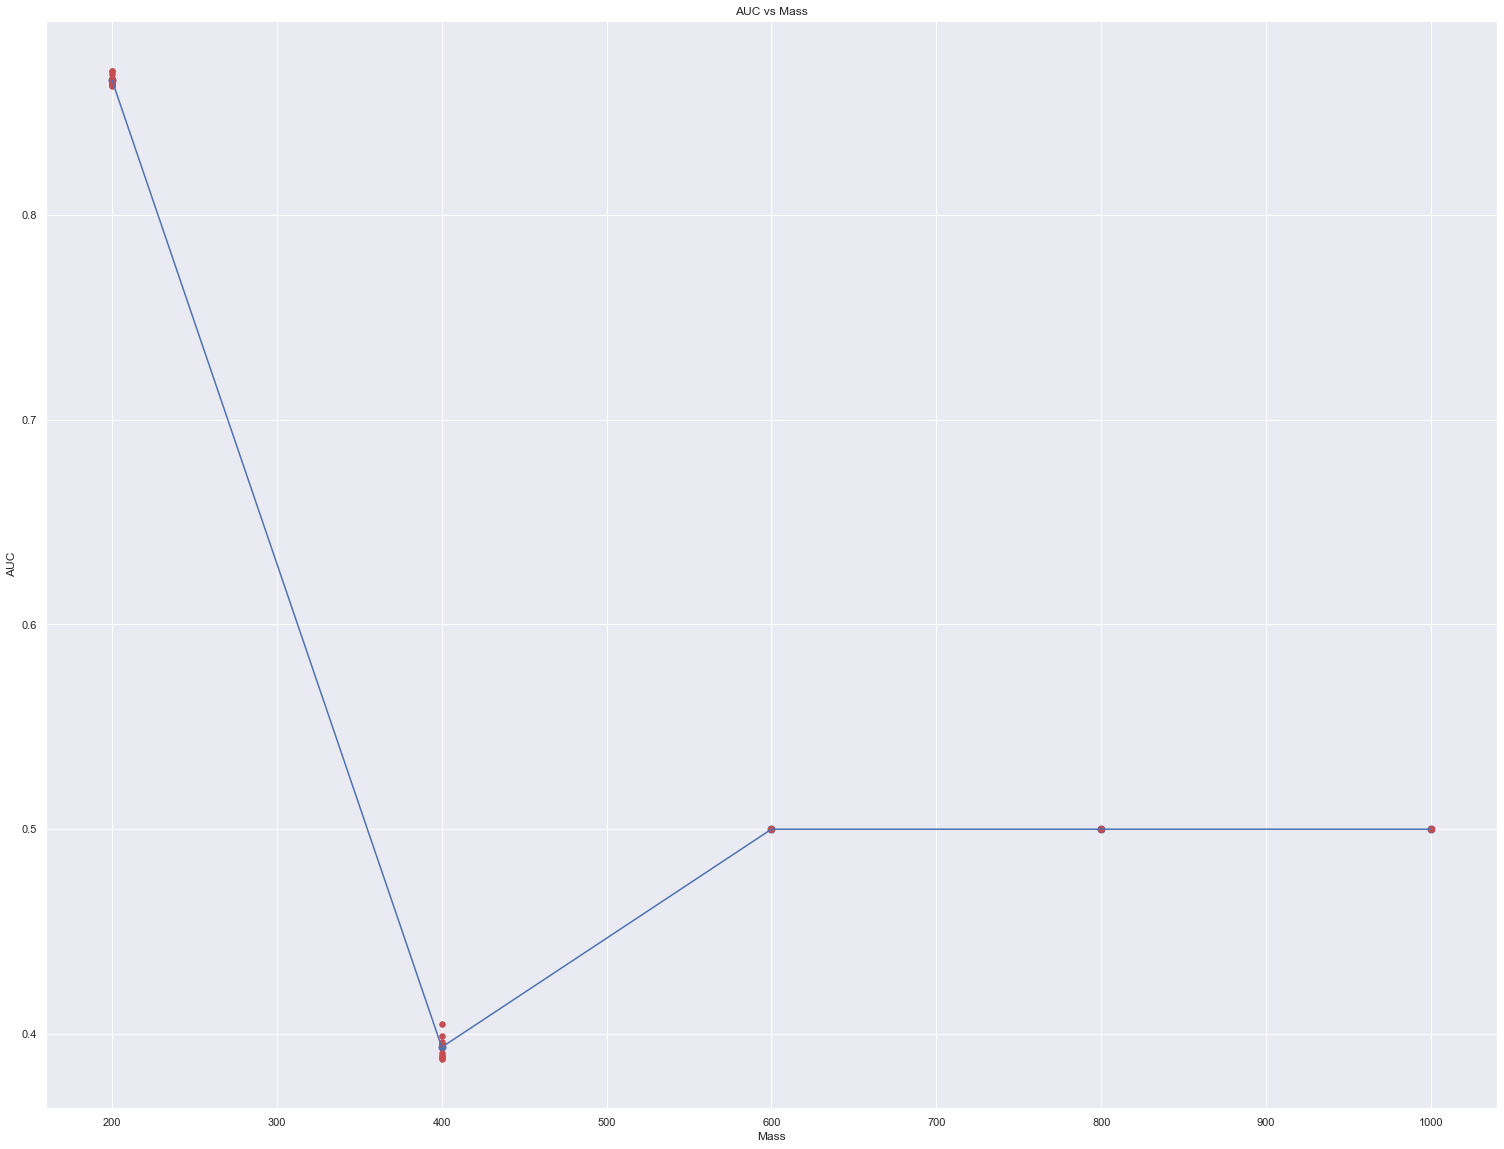

{0: [0.8643, 0.3907, 0.5, 0.5, 0.5],
 1: [0.8639, 0.3952, 0.5, 0.5, 0.5],
 2: [0.8637, 0.3882, 0.5, 0.5, 0.5],
 3: [0.869, 0.4048, 0.5, 0.5, 0.5],
 4: [0.8631, 0.396, 0.5, 0.5, 0.5],
 5: [0.8636, 0.3952, 0.5, 0.5, 0.5],
 6: [0.8706, 0.3991, 0.5, 0.5, 0.5],
 7: [0.8669, 0.3878, 0.5, 0.5, 0.5],
 8: [0.8633, 0.389, 0.5, 0.5, 0.5],
 9: [0.8705, 0.3892, 0.5, 0.5, 0.5]}

In [91]:
# evaluate on "test masses"
auc_with_error(model_gen, data, auc_index=2, masses=test_mass, bin_size=100, num_folds=10)

[0] Mass: 100
31/31 [==============================] - 0s 3ms/step - loss: 0.4204 - binary_accuracy: 0.7944 - auc_6: 0.8952 - precision_6: 0.8145 - recall_6: 0.6675
[1] Mass: 100
31/31 [==============================] - 0s 3ms/step - loss: 0.3983 - binary_accuracy: 0.8054 - auc_6: 0.9034 - precision_6: 0.8083 - recall_6: 0.6792
[2] Mass: 100
31/31 [==============================] - 0s 4ms/step - loss: 0.4123 - binary_accuracy: 0.7983 - auc_6: 0.8931 - precision_6: 0.7946 - recall_6: 0.6772
[3] Mass: 100
31/31 [==============================] - 0s 3ms/step - loss: 0.4090 - binary_accuracy: 0.8039 - auc_6: 0.8972 - precision_6: 0.8049 - recall_6: 0.6833
[4] Mass: 100
31/31 [==============================] - 0s 3ms/step - loss: 0.3951 - binary_accuracy: 0.8101 - auc_6: 0.9036 - precision_6: 0.8085 - recall_6: 0.6820
[5] Mass: 100
31/31 [==============================] - 0s 4ms/step - loss: 0.4112 - binary_accuracy: 0.7993 - auc_6: 0.8924 - precision_6: 0.7900 - recall_6: 0.6627
[6] Mass: 

50/50 [==============================] - 0s 3ms/step - loss: 17.9112 - binary_accuracy: 0.4563 - auc_6: 0.5000 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
[8] Mass: 1000
50/50 [==============================] - 0s 3ms/step - loss: 18.1203 - binary_accuracy: 0.4499 - auc_6: 0.5000 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
[9] Mass: 1000
50/50 [==============================] - 0s 3ms/step - loss: 18.0997 - binary_accuracy: 0.4506 - auc_6: 0.5000 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00


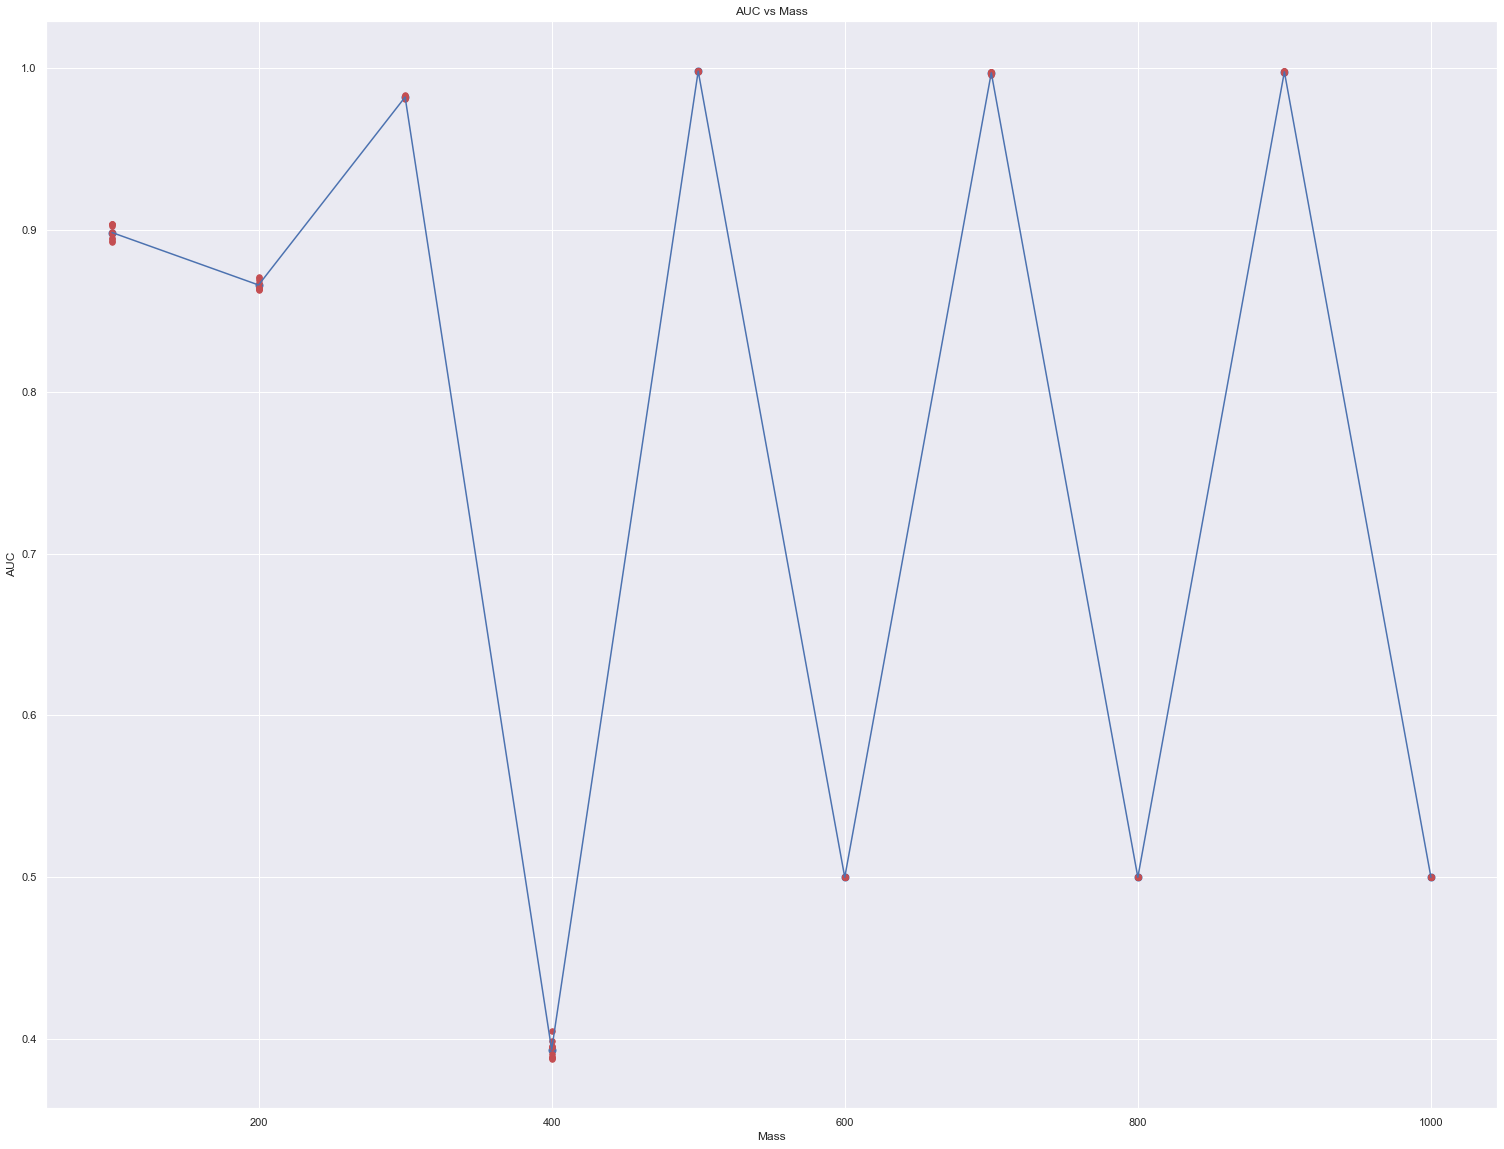

{0: [0.8952, 0.8643, 0.9819, 0.3907, 0.9984, 0.5, 0.9973, 0.5, 0.9971, 0.5],
 1: [0.9034, 0.8639, 0.9816, 0.3952, 0.9983, 0.5, 0.9962, 0.5, 0.9976, 0.5],
 2: [0.8931, 0.8637, 0.9815, 0.3882, 0.998, 0.5, 0.9972, 0.5, 0.9977, 0.5],
 3: [0.8972, 0.869, 0.9822, 0.4048, 0.998, 0.5, 0.9968, 0.5, 0.9977, 0.5],
 4: [0.9036, 0.8631, 0.9806, 0.396, 0.9978, 0.5, 0.9976, 0.5, 0.9979, 0.5],
 5: [0.8924, 0.8636, 0.9816, 0.3952, 0.9978, 0.5, 0.9977, 0.5, 0.9979, 0.5],
 6: [0.9034, 0.8706, 0.9819, 0.3991, 0.9984, 0.5, 0.9975, 0.5, 0.9978, 0.5],
 7: [0.9021, 0.8669, 0.9828, 0.3878, 0.9977, 0.5, 0.9969, 0.5, 0.9976, 0.5],
 8: [0.8944, 0.8633, 0.9833, 0.389, 0.9979, 0.5, 0.9969, 0.5, 0.9974, 0.5],
 9: [0.8984, 0.8705, 0.9823, 0.3892, 0.9981, 0.5, 0.9959, 0.5, 0.9977, 0.5]}

In [92]:
# evaluate on "all masses"
auc_with_error(model_gen, data, auc_index=2, masses=all_mass, bin_size=100, num_folds=10)

## Explore Data
* Plot each input feature (distinguish between *signal* and *background*)
* Find out correlations between *mass* and the features
---

In [105]:
# a sample of the dataset
df = data.ds
df.sample(25)

,mA,dimuon_deltar,dimuon_deltaphi,dimuon_deltaeta,dimuon_M,met_pt,met_phi,met_eta,bjet_n,bjet_1_pt,...,ljet_n,ljet_1_pt,ljet_1_eta,deltar_bjet1_dimuon,deltapt_bjet1_dimuon,deltaeta_bjet1_dimuon,deltaphi_bjet1_dimuon,PU_Weight,weight,type
1408315,384.670227,4.046986,2.731689,2.985962,243.084976,23.144300,2.552734,0.0,0.0,73.812500,...,0.0,51.843750,-0.747925,0.000000,0.000000,0.000000,0.000000,1.125935,1.000000,0.0
1273368,250.670364,3.562294,2.729492,2.289062,144.584396,101.586388,-0.450989,0.0,0.0,128.750000,...,3.0,50.312500,0.477783,0.000000,0.000000,0.000000,0.000000,0.992675,1.000000,0.0
212094,200.000000,3.074126,2.947675,0.872620,196.133270,33.130215,-0.712891,0.0,1.0,28.968750,...,0.0,20.781250,0.384399,3.054115,8.564294,1.290247,2.768190,0.998296,2.186612,1.0
1820576,808.445129,3.122065,2.146466,2.267151,142.469498,100.010307,1.407959,0.0,1.0,114.937500,...,2.0,79.562500,-1.796387,2.187080,57.923920,1.241279,1.800708,1.073452,1.000000,0.0
574502,645.587769,3.131184,2.959747,1.021866,124.209908,67.626747,-2.242188,0.0,0.0,51.718750,...,0.0,29.609375,-0.648071,0.000000,0.000000,0.000000,0.000000,1.120658,1.000000,0.0
1890823,887.474548,2.713633,1.448730,2.294556,183.328262,96.825478,-0.542847,0.0,2.0,43.281250,...,2.0,115.125000,0.943237,0.736863,47.873302,0.329077,0.659299,1.091130,1.000000,0.0
720477,400.000000,1.910801,0.164734,1.903687,124.697037,20.504135,-1.376221,0.0,0.0,83.312500,...,0.0,25.671875,-0.014107,0.000000,0.000000,0.000000,0.000000,0.965139,0.542467,1.0
1028218,500.000000,3.413077,3.114118,1.396912,515.917969,70.976639,0.041389,0.0,1.0,41.406250,...,1.0,31.703125,2.292480,4.795286,1.783327,4.090475,2.502554,1.018162,0.553207,1.0
894499,450.000000,3.085387,3.085327,0.019287,454.544495,29.051786,3.013672,0.0,0.0,31.515625,...,1.0,46.843750,1.575928,0.000000,0.000000,0.000000,0.000000,0.982873,0.535598,1.0
2335836,592.042725,2.371877,1.943298,1.359924,146.938782,60.289013,3.047852,0.0,1.0,79.750000,...,1.0,21.578125,1.009766,2.553526,4.731050,0.422165,2.518387,1.036924,1.000000,0.0


In [25]:
def histogram(col: str, bins=None):
    plt.title(col)
    plt.hist(data.background[col], bins=bins, alpha=0.3, label='bkg', color='red')
    plt.hist(data.signal[col], bins=bins, alpha=0.7, label='sig', color='blue')
    plt.legend()

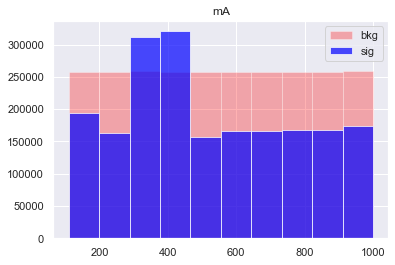

In [26]:
# bkg vs singla mass distribution
histogram(col='mA')

In [63]:
columns = data.train_features.columns
columns

Index(['dimuon_deltar', 'dimuon_deltaphi', 'dimuon_deltaeta', 'met_pt',
       'deltar_bjet1_dimuon', 'deltapt_bjet1_dimuon', 'deltaeta_bjet1_dimuon',
       'bjet_1_pt', 'bjet_1_eta', 'ljet_1_pt', 'ljet_1_eta', 'bjet_n',
       'ljet_n'],
      dtype='object')

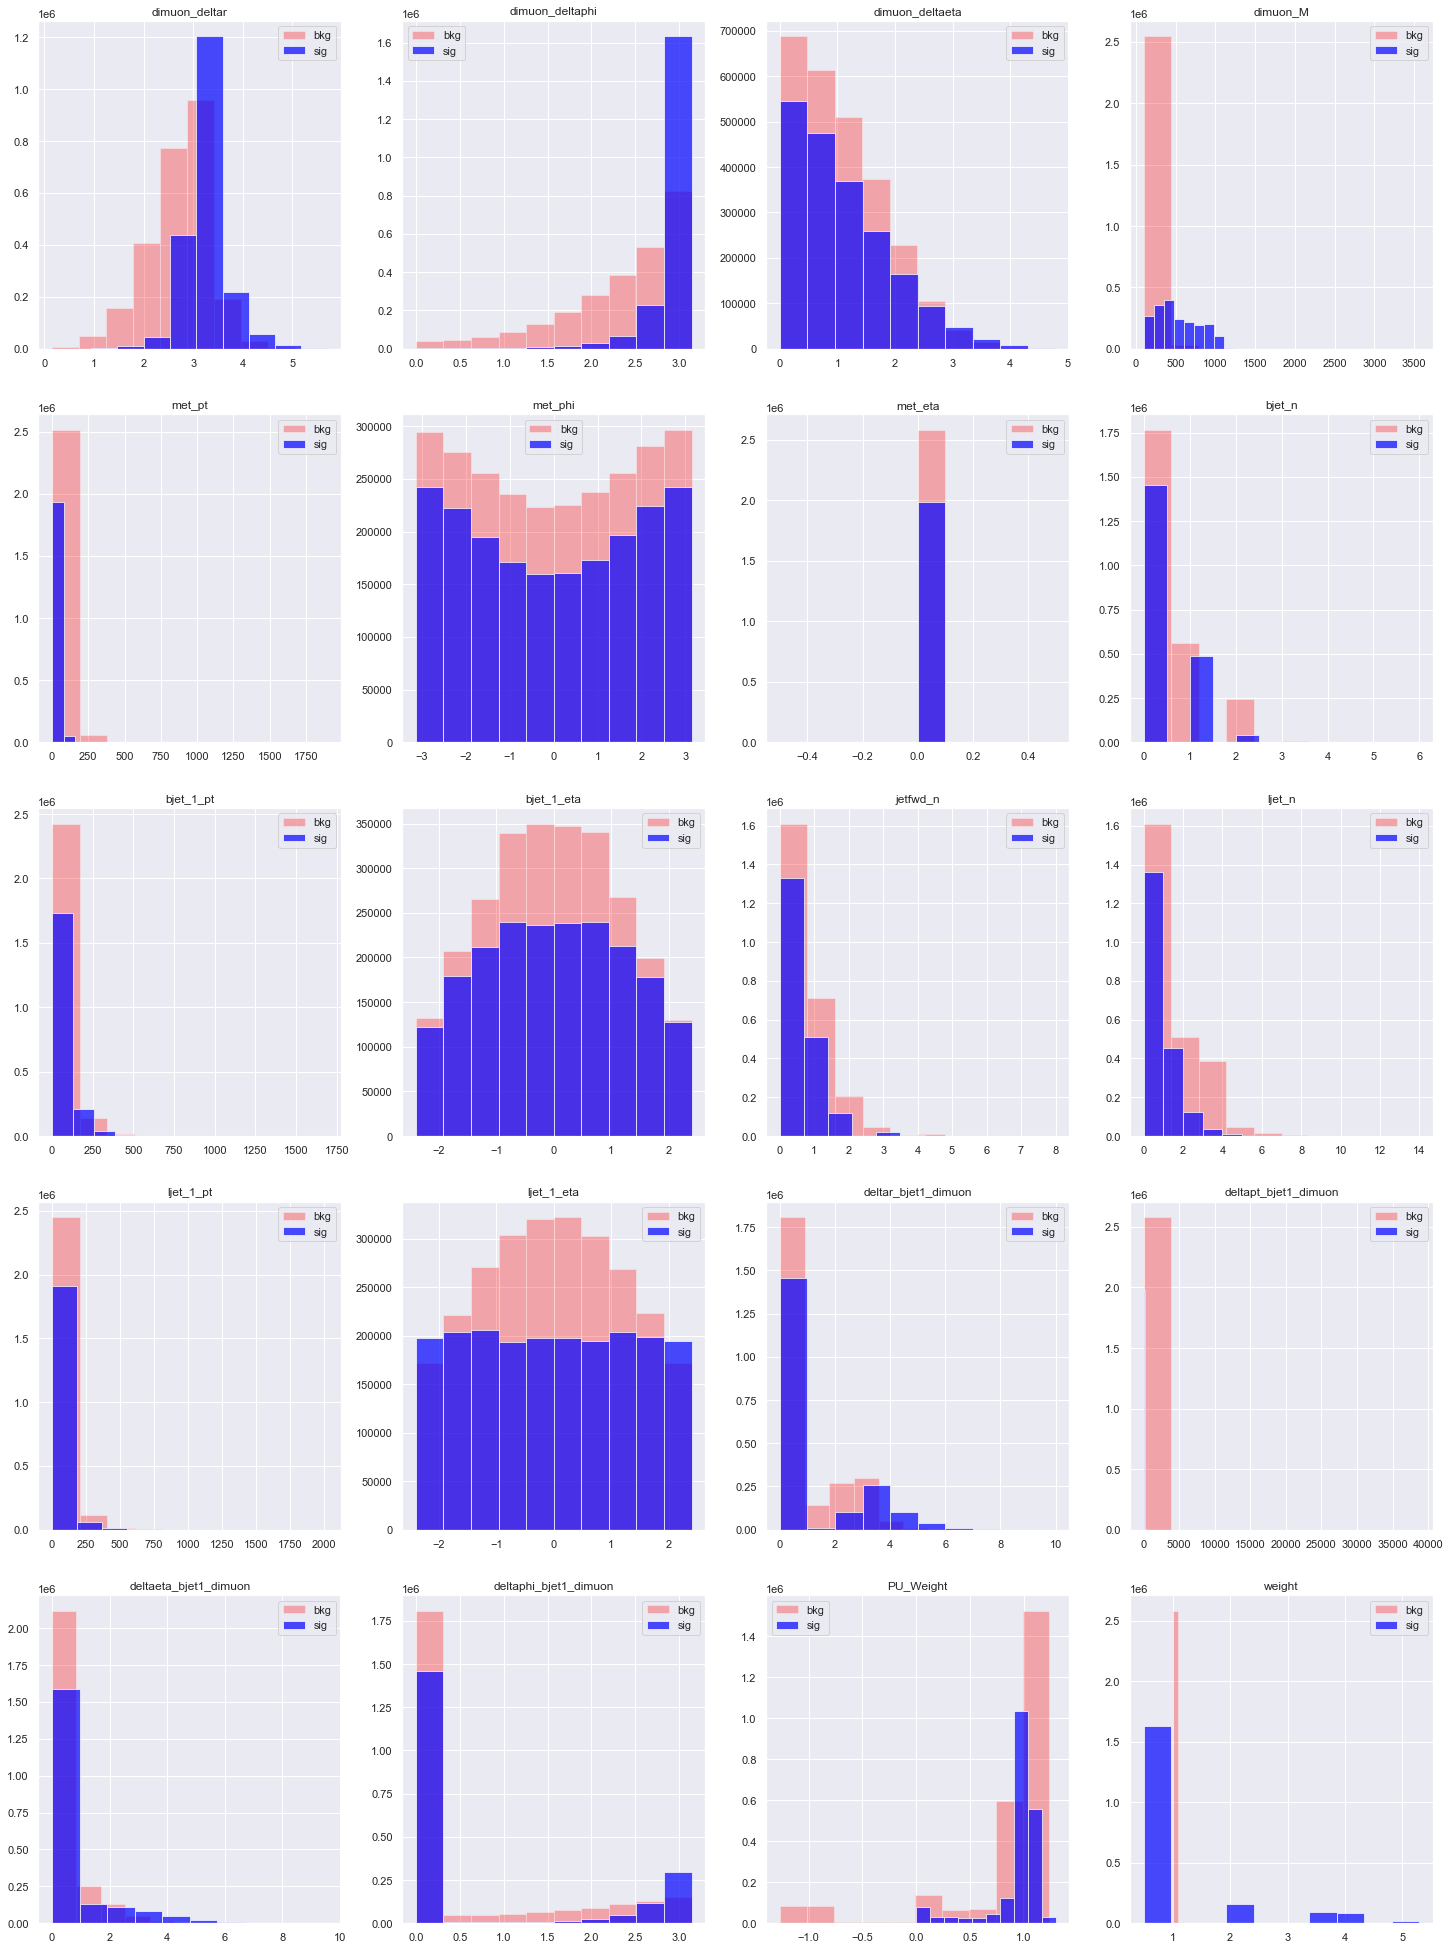

In [131]:
# compare feature distribution
plt.figure(figsize=(25, 35))

for i, col in enumerate(columns):
    plt.subplot(5, 4, i + 1)
    histogram(col)

In [161]:
def scatter(col: str, limit=10_000, seed=SEED):
    mass_bkg = data.background['mA'].sample(limit, random_state=seed)
    col_bkg = data.background[col].sample(limit, random_state=seed)
    
    mass_sig = data.signal['mA'].sample(limit, random_state=seed)
    col_sig = data.signal[col].sample(limit, random_state=seed)
    
    plt.title(f'mA vs {col}')
    plt.scatter(mass_bkg, col_bkg, alpha=0.3, label='bkg', color='red', marker='o', s=10)
    plt.scatter(mass_sig, col_sig, alpha=0.7, label='sig', color='blue', marker='s', s=40)
    
    plt.xlabel('mA')
    plt.ylabel(col)
    plt.legend()

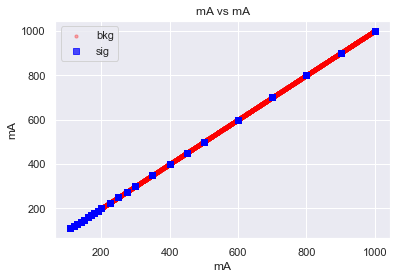

In [162]:
scatter('mA')

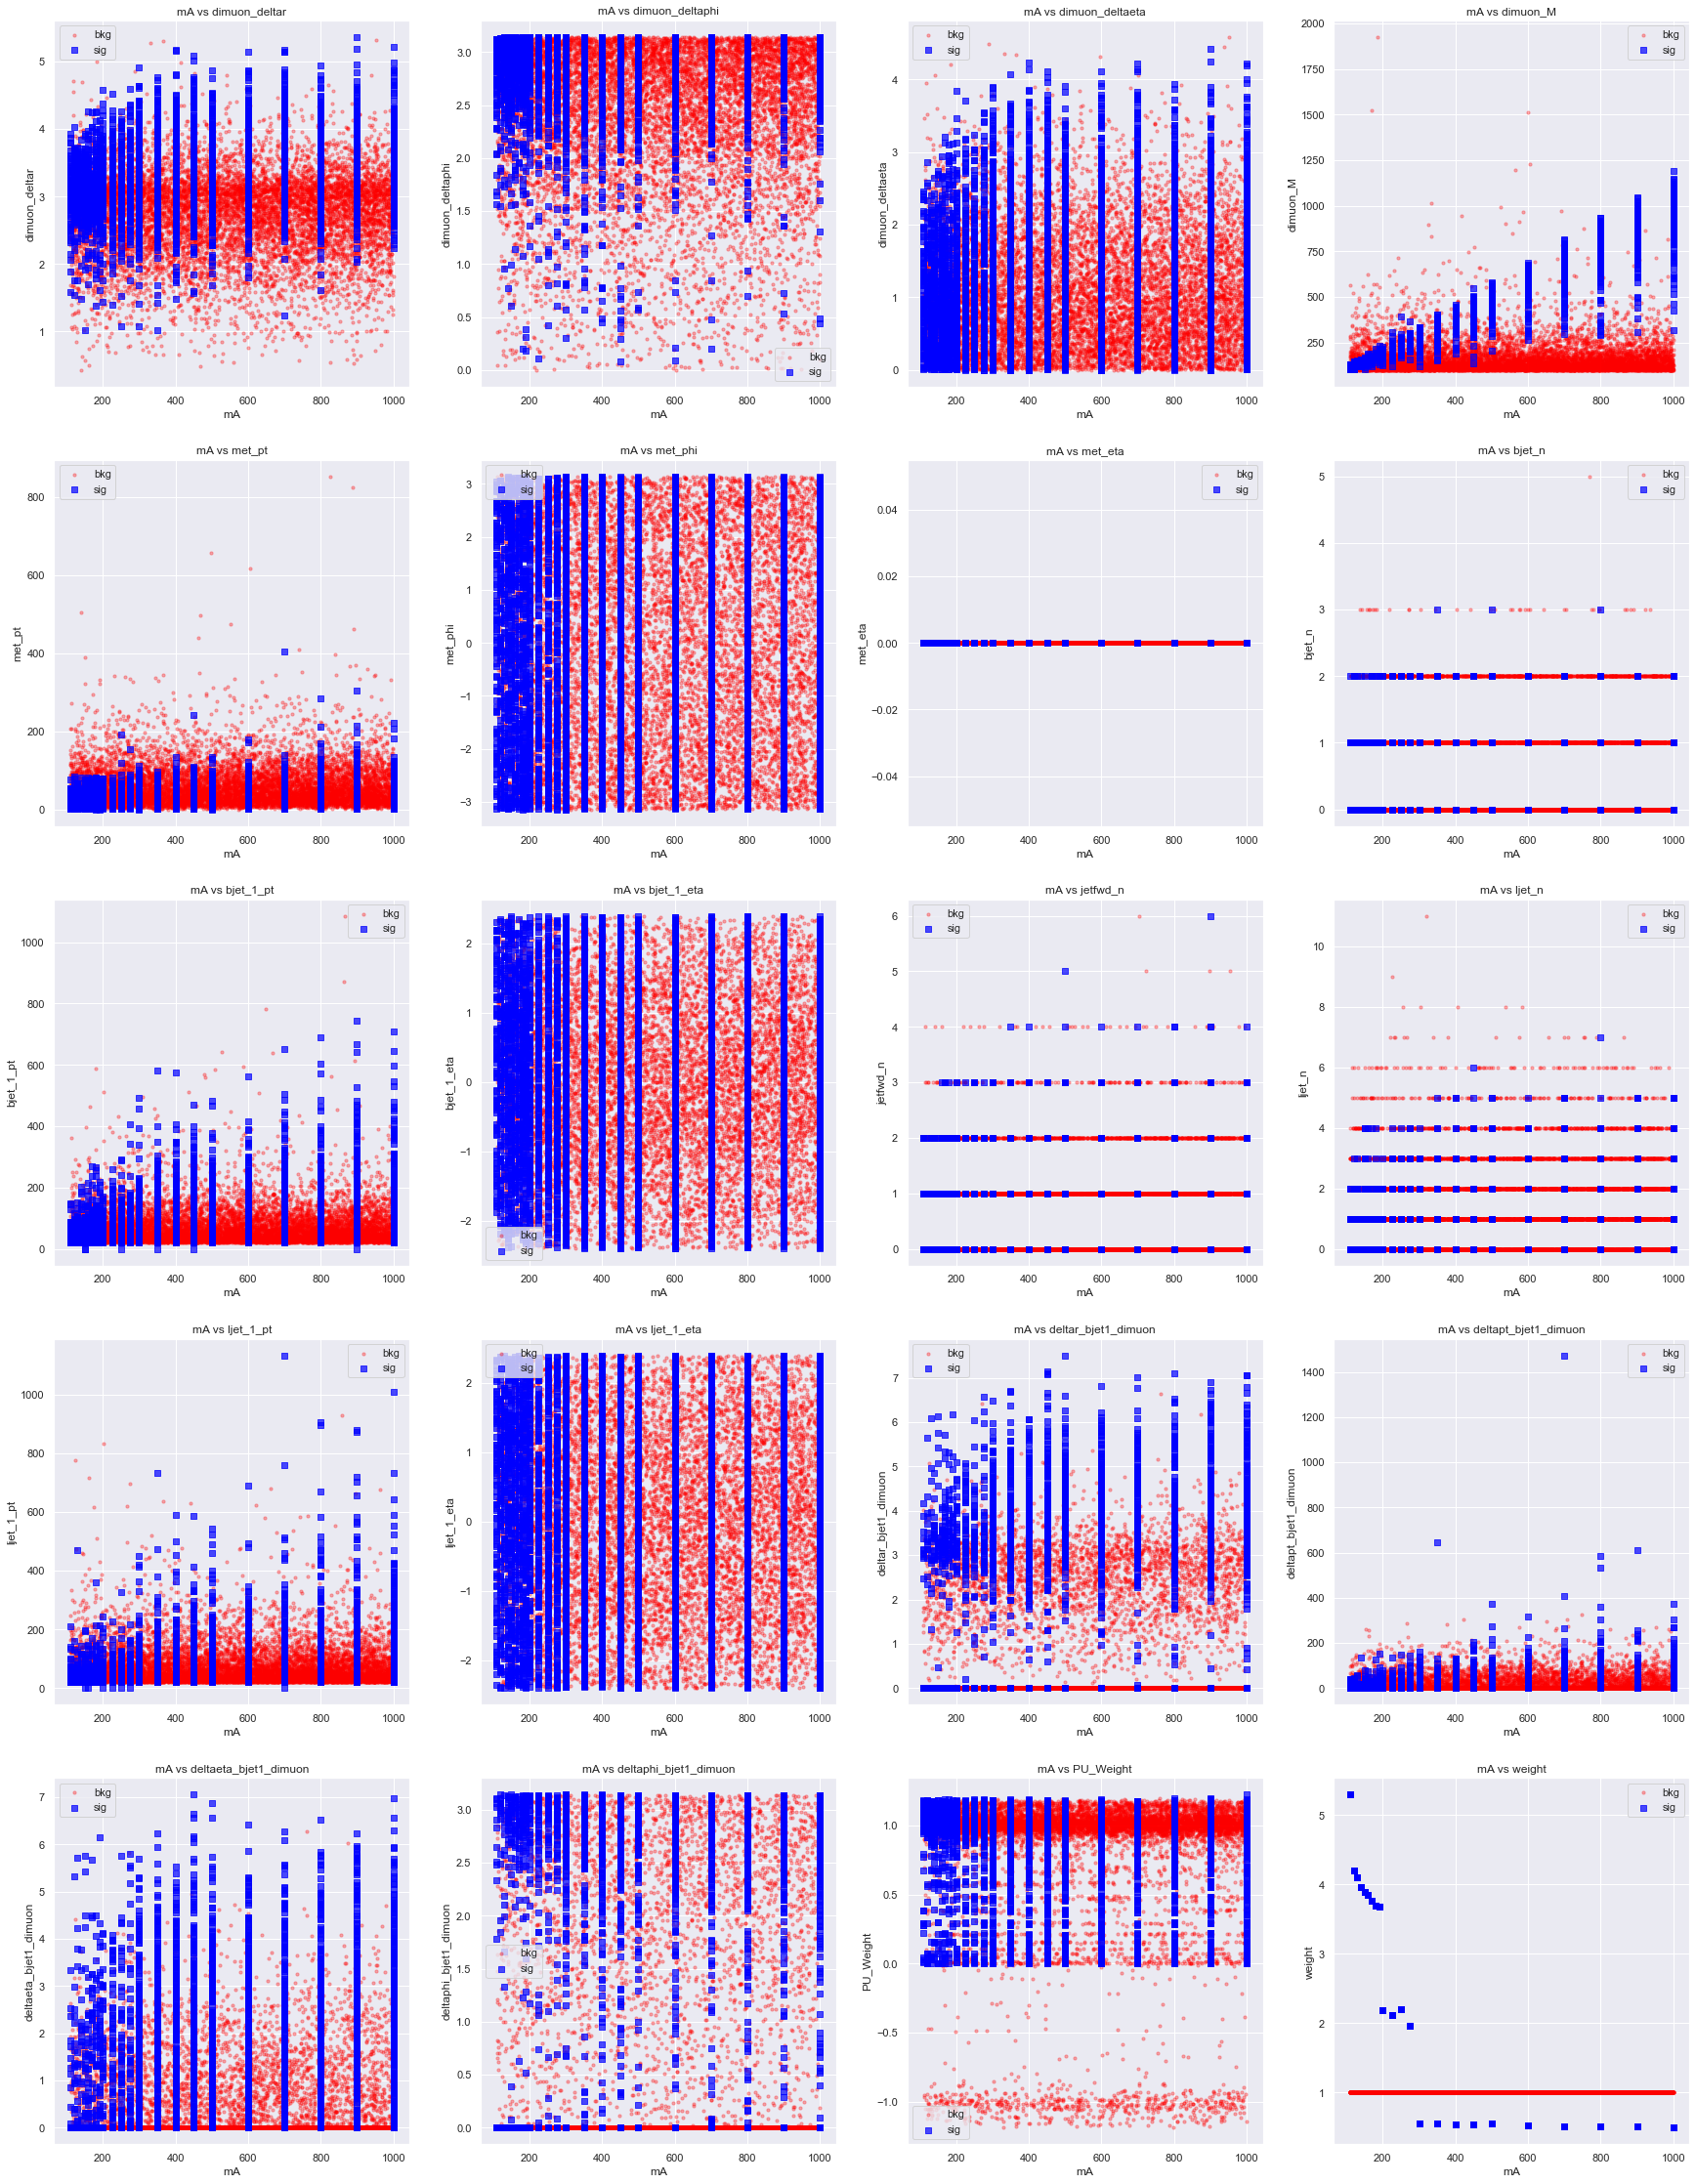

In [164]:
plt.figure(figsize=(30, 40))

for i, col in enumerate(columns):
    plt.subplot(5, 4, i + 1)
    scatter(col)

* [WIP] trying to do some 3D plots that show the distribution of a single feature for signal and bkg, w.r.t. the mass distribution

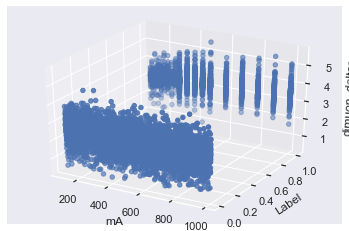

In [67]:
from mpl_toolkits.mplot3d import Axes3D

sample = data.ds.sample(10_000, random_state=SEED)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = sample['mA']
y = sample['type']
z = sample[columns[0]]

ax.set_xlabel('mA')
ax.set_ylabel('Label')
ax.set_zlabel(columns[0])

ax.scatter(x, y, z)

plt.show()

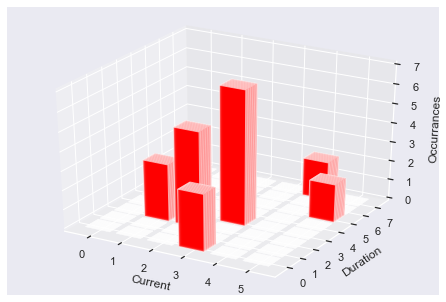

In [70]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
 
data = [ [0,0,0,3,0,0],
 [0,0,0,0,0,0],
 [0,3,5,0,0,0],
 [0,0,0,7,0,0],
 [0,0,0,0,0,0],
 [0,0,0,0,0,2],
 [0,0,0,0,0,0],
 [0,0,0,0,2,0] ]

fig = plt.figure()
ax = Axes3D(fig)
 
def plot3d(data, ax, barcolor):
    """ Takes in a matrix (see structure above) and generate a pseudo-3D histogram by overlaying close, semitransparent bars. """
    for duration, occurrence in zip(range(len(data)), data):
        current = range(len(occurrence))
        barband = range(-45, 45, 5)
        for modifier in barband:
            ax.bar(current, occurrence, zs=duration+(float(modifier)/100), zdir='y', color=barcolor, alpha=0.6)
 
    ax.set_xlabel('Current')
    ax.set_ylabel('Duration')
    ax.set_zlabel('Occurrances')
    

plot3d(data, ax, 'red')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

 
def plot3d(data, col, barcolor):
    """ Takes in a matrix (see structure above) and generate a pseudo-3D histogram by overlaying close, semitransparent bars. """
    fig = plt.figure()
    ax = Axes3D(fig)
    
    x = data['mA']
    y = data['type']
    z = data[col]
    
    for duration, occurrence in zip(y, z):
#         current = range(len(occurrence))  # = x
        barband = range(-45, 45, 5)
        
        for modifier in barband:
            ax.bar(x, occurrence, zs=duration + (float(modifier) / 100), zdir='y', color=barcolor, alpha=0.6)
 
    ax.set_xlabel('mA')
    ax.set_ylabel('Label')
    ax.set_zlabel(col)

    

plot3d(sample, columns[0], 'red')